# Summary
In this notebook we impute values for `china.csv`.

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import torch

from tqdm import tqdm

import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer, Conv1d



## Model

In [15]:
def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu
    raise ValueError("activation should be relu/gelu, not {}".format(activation))


class TSTransformerEncoderCNN(nn.Module):

    def __init__(self, input_dimension, output_dimension, hidden_dimmension,
                 attention_heads, encoder_number_of_layers,  
                 dropout, dim_feedforward=512, kernel_size=3, activation='gelu'):
        super(TSTransformerEncoderCNN, self).__init__()

        self.project_input = nn.Linear(input_dimension, hidden_dimmension)

        self.hidden_dimmension = hidden_dimmension
        if attention_heads is None:
            attention_heads=hidden_dimmension//64
        self.attention_heads = attention_heads

        self.encoder = nn.Linear(input_dimension, hidden_dimmension) # using linear projection instead
        encoder_layer = TransformerEncoderLayer(hidden_dimmension, self.attention_heads, dim_feedforward, dropout, activation=activation)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, encoder_number_of_layers)

        self.output_layer = nn.Linear(hidden_dimmension, output_dimension)

        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)

        self.input_dimension = output_dimension

        self.cnn = nn.Conv1d(in_channels = self.hidden_dimmension, 
                             out_channels = 12, # 2 * hid_dim, 
                             kernel_size = kernel_size, 
                             padding = (kernel_size - 1) // 2)
        


    def forward(self, src,trg_):#, padding_masks):
        """
        Args:
            X: (batch_size, seq_length, feat_dim) torch tensor of masked features (input)
            padding_masks: (batch_size, seq_length) boolean tensor, 1 means keep vector at this position, 0 means padding
        Returns:
            output: (batch_size, seq_length, feat_dim)
        """

        # permute because pytorch convention for transformers is [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        src = self.project_input(src)                                                     # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
                                                         
        # NOTE: logic for padding masks is reversed to comply with definition in MultiHeadAttention, TransformerEncoderLayer
        # output = self.transformer_encoder(src, src_key_padding_mask=~padding_masks)     # (seq_length, batch_size, d_model)
        output = self.transformer_encoder(src)     # (seq_length, batch_size, d_model)
        output = self.act(output)                                                       # the output transformer encoder/decoder embeddings don't include non-linearity
        output = self.dropout1(output)
        output = output.permute(1, 2, 0) # NCL
        output = self.cnn(output)
        # print('Output:', output.shape)
        # Most probably defining a Linear(d_model,feat_dim) vectorizes the operation over (seq_length, batch_size).
        # output = self.output_layer(output)  # (batch_size, seq_length, feat_dim)
        return output

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TSTransformerEncoderCNN(input_dimension=12, 
                             output_dimension=12,
                             hidden_dimmension=64, 
                             attention_heads=None,
                             encoder_number_of_layers=4, 
                             dropout=0.5).to(device)





## Load Data

In [17]:
import pickle
os.chdir('/home/david/Desktop/projects/thesis/upstream_seq2seq/')
from dataloader.DataLoader import DataGenerator_12leads

DESTINATION_FOLDER = './data/processed/'
BATCH_SIZE = 4
with open(DESTINATION_FOLDER+"splits.pkl", 'rb') as handle:
    splits = pickle.load(handle)

train_generator = DataGenerator_12leads(
                                data_folder_path=DESTINATION_FOLDER, # path to relevant folder
                                batch_size=BATCH_SIZE,                        # batch size
                                list_IDs=splits['train'],            # list of relevat IDs (each ID is given in a <file>_<person> format)
                                shuffle = True                       # Whether to shuffle the list of IDs at the end of each epoch.
                                )

X1,X2 = train_generator.__getitem__(0)
X1 = X1[:,:,:450]
X2 = X2[:,:,:450]

print(X1.shape, X2.shape)
X1, X2

(4, 12, 450) (4, 12, 450)


(array([[[ 181,  181,  181, ...,   49,  -24, -127],
         [ -93,  -93,  -93, ...,  971, 1054,  859],
         [-273, -273, -273, ...,  922, 1078,  986],
         ...,
         [   0,    0,    0, ...,    0,    0,    0],
         [-215, -215, -224, ..., 2108, 2318, 2108],
         [   0,    0,    0, ...,    0,    0,    0]],
 
        [[  29,   39,   34, ...,  -39,  -49,  -44],
         [  10,   20,   20, ...,  -88,  -83,  -83],
         [ -20,  -20,  -15, ...,  -49,  -34,  -39],
         ...,
         [-132, -132, -132, ..., -132, -132, -137],
         [ 468,  464,  454, ..., -127, -117, -127],
         [ 522,  478,  468, ..., -127, -117, -117]],
 
        [[ -82,  -97, -107, ...,  -78,  -68,  -68],
         [  92,   78,   73, ...,   48,   53,   58],
         [ 175,  175,  180, ...,  126,  122,  126],
         ...,
         [  53,   48,   48, ...,  107,  107,  107],
         [  -4,   -9,   -9, ...,   -9,   -9,   -9],
         [   9,    4,   -4, ...,    0,   -9,   -9]],
 
        [[ -2

In [19]:
# fix shapes (convert into -> [length, batch_size, channels])
src_ = np.float32(np.transpose(X1, axes=(2,0,1)))
# trg_ = np.float32(np.transpose(trg_, axes=(2,0,1)))

src_ = torch.from_numpy(src_)

src_ = src_.to(device)
# trg_ = trg_.to(device)

# step
# optimizer.zero_grad()
y = model(src_, None)
y.shape





torch.Size([4, 12, 450])

## Data

In [4]:
df_scrutinized = pd.read_csv('../data/one-year-project/new_china_features_05.csv', index_col=0)
df_scrutinized.iloc[:5]

0     1     2     3     4     5     6     7     8     9  \
index                                                                          
china_LII_Q0003    6.0   6.0   5.0   4.0   3.0   1.0   0.0  -2.0  -2.0  -1.0   
china_LIII_Q0003  53.0  53.0  52.0  52.0  51.0  49.0  47.0  46.0  46.0  45.0   
china_aVR_Q0003   21.0  21.0  21.0  22.0  22.0  24.0  24.0  25.0  25.0  24.0   
china_aVL_Q0003  -50.0 -50.0 -50.0 -50.0 -50.0 -48.0 -47.0 -47.0 -47.0 -45.0   
china_aVF_Q0003   30.0  30.0  28.0  28.0  27.0  25.0  24.0  22.0  22.0  22.0   

                  ...  4990  4991  4992  4993  4994  4995  4996  4997  4998  \
index             ...                                                         
china_LII_Q0003   ...  37.0  29.0  24.0  20.0  19.0  17.0  15.0  13.0  10.0   
china_LIII_Q0003  ...  83.0  69.0  59.0  54.0  50.0  48.0  47.0  46.0  43.0   
china_aVR_Q0003   ...   4.0   6.0   6.0   7.0   6.0   7.0   9.0  10.0  12.0   
china_aVL_Q0003   ... -65.0 -54.0 -47.0 -44.0 -41.0 -39.0 -39.0 -39.0 -38.0   
china_aVF_Q0003   ...  60.0  49.0  42.0  37.0  34.0  33.0  31.0  30.0  27.0   

                  4999  
index                   
china_LII_Q0003    6.0  
china_LIII_Q0003  42.0  
china_aVR_Q0003   15.0  
china_aVL_Q0003  -39.0  
china_aVF_Q0003   24.0  

[5 rows x 5000 columns]

# Predition Function

In [5]:
# Create a list of uniquely identified reading indices
signals_names = list({x.split('_')[-1] for x in df_scrutinized.index})

# example
signal_name = signals_names[0]


def predict(signal_name):
    """
    the prediction will go as follows
    1. get a reading of length 5000
    2. define empty data X_imputed <- (1,12,0)
    3. adjust data to model:
        - jump 500 at a time. Get data X = (1,12,500)
        - expand dim so shape would be (1,12,500)
        - pass through model. Y = model(X)
        - append. X_imputed <- concat(X_imputed, Y)
    4. Convert to pd and return it nicely.
    """

    # Get order of leads in each reading, taken from dissertation
    order_of_leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']

    # Load scalar
    scalar = MinMaxScaler()

    # Create hypotetical list of leads, it the reading was whole
    sorted_all_leads = [f'china_{x}_{signal_name}' for x in order_of_leads]

    # scale readins
    available_leads = list(df_scrutinized[df_scrutinized.index.isin(sorted_all_leads)].index)
    relevant_data_for_reading = df_scrutinized[df_scrutinized.index.isin(available_leads)].T
    scaled_reading = pd.DataFrame(scalar.fit_transform(relevant_data_for_reading).T)
    scaled_reading.index = available_leads

    # Sanity check
    # ---------------
    # plt.plot(scaled_reading.iloc[0,:])
    # plt.show()
    # plt.plot(relevant_data_for_reading.T.iloc[0,:])
    # plt.show()

    # Figure out which leads are missing
    missing_leads = [x for x in sorted_all_leads if x not in available_leads]

    # Create a dataFrame
    missing_data_addition = pd.DataFrame({x:np.repeat(0,5000) for x in missing_leads}).T

    # Concat missing data and given leads
    scaled_reading_with_missing = pd.concat([scaled_reading,missing_data_addition],
                                            axis=0)
    scaled_reading_with_missing = scaled_reading_with_missing.loc[sorted_all_leads]

    # Get values and reshape according to [batch_size, channels, window] = (1, 12, 5000)
    location = 0
    window = 500
    Ys = []
    
    for _ in range(10):
        
        # get only relevant timestamps
        X_np = scaled_reading_with_missing.iloc[:,location:(location+window)].values
        X_np = np.expand_dims(np.float32(X_np),0)
        X_np = np.transpose(X_np, axes=(2,0,1))
        src_ = torch.from_numpy(X_np)
        src_ = src_.to(device)

        # predict
        with torch.no_grad():
            Y = model(src_,None).cpu().numpy()
        Y = np.squeeze(np.transpose(Y,axes=(2,1,0)))
        Ys.append(pd.DataFrame(Y))

        # update location on the signal
        location += window
    scaled_reading_with_imputed = pd.concat(Ys, axis=1)
    scaled_reading_with_imputed.index = sorted_all_leads   

    return scaled_reading_with_imputed


In [6]:
predicted = predict(signal_name)
predicted


0         1         2         3         4         5    \
china_LI_Q1529    0.704887  0.706543  0.708186  0.708827  0.709410  0.709247   
china_LII_Q1529   0.768353  0.772560  0.778216  0.783187  0.785760  0.787939   
china_LIII_Q1529  0.649133  0.651815  0.656077  0.660816  0.663095  0.665798   
china_aVF_Q1529   0.707493  0.710938  0.715896  0.720750  0.723176  0.725616   
china_aVL_Q1529   0.615011  0.614622  0.613552  0.611900  0.611338  0.610263   
china_aVR_Q1529   0.440243  0.437562  0.434390  0.432375  0.431365  0.431065   
china_V1_Q1529    0.478601  0.477597  0.476606  0.476878  0.477409  0.478669   
china_V2_Q1529    0.549060  0.550035  0.551048  0.552591  0.554408  0.556362   
china_V3_Q1529    0.674346  0.677665  0.681581  0.685153  0.688143  0.690828   
china_V4_Q1529    0.839175  0.843774  0.849039  0.853016  0.855996  0.858073   
china_V5_Q1529    0.920885  0.925640  0.930979  0.934438  0.936676  0.937639   
china_V6_Q1529    0.885432  0.889384  0.893867  0.896649  0.898167  0.898494   

                       6         7         8         9    ...       490  \
china_LI_Q1529    0.708556  0.708004  0.706538  0.704584  ...  0.659091   
china_LII_Q1529   0.787800  0.786894  0.785051  0.783933  ...  0.709711   
china_LIII_Q1529  0.666652  0.666665  0.666698  0.668104  ...  0.644051   
china_aVF_Q1529   0.725972  0.725526  0.724620  0.724764  ...  0.675635   
china_aVL_Q1529   0.609796  0.609885  0.609550  0.608439  ...  0.602471   
china_aVR_Q1529   0.432084  0.433552  0.436027  0.438690  ...  0.507966   
china_V1_Q1529    0.480832  0.483082  0.486150  0.489358  ...  0.545865   
china_V2_Q1529    0.559008  0.561658  0.564384  0.566451  ...  0.589210   
china_V3_Q1529    0.693226  0.695111  0.696355  0.696624  ...  0.663083   
china_V4_Q1529    0.859275  0.859768  0.858856  0.856402  ...  0.764695   
china_V5_Q1529    0.937289  0.936410  0.933577  0.929102  ...  0.804585   
china_V6_Q1529    0.897396  0.895986  0.892741  0.888522  ...  0.777334   

                       491       492       493       494       495       496  \
china_LI_Q1529    0.655492  0.651400  0.647772  0.643816  0.640480  0.636479   
china_LII_Q1529   0.706095  0.701125  0.697756  0.695193  0.693052  0.690183   
china_LIII_Q1529  0.643877  0.642918  0.643298  0.644566  0.645722  0.646885   
china_aVF_Q1529   0.673741  0.670777  0.669284  0.668637  0.668146  0.667293   
china_aVL_Q1529   0.600604  0.598961  0.597077  0.594337  0.592048  0.589494   
china_aVR_Q1529   0.511257  0.515628  0.519360  0.522352  0.524997  0.528478   
china_V1_Q1529    0.547840  0.550484  0.552755  0.554318  0.555675  0.557748   
china_V2_Q1529    0.587688  0.586279  0.584640  0.582018  0.579665  0.577542   
china_V3_Q1529    0.658778  0.653692  0.648827  0.643665  0.638896  0.633836   
china_V4_Q1529    0.757725  0.749352  0.741317  0.733341  0.725969  0.717662   
china_V5_Q1529    0.796360  0.786538  0.777155  0.767871  0.759493  0.749634   
china_V6_Q1529    0.770384  0.762148  0.754526  0.746938  0.740271  0.732237   

                       497       498       499  
china_LI_Q1529    0.632109  0.628715  0.625362  
china_LII_Q1529   0.684799  0.681238  0.675231  
china_LIII_Q1529  0.645587  0.645284  0.642167  
china_aVF_Q1529   0.663954  0.662023  0.657462  
china_aVL_Q1529   0.587677  0.585998  0.585425  
china_aVR_Q1529   0.532790  0.535993  0.539764  
china_V1_Q1529    0.559859  0.561542  0.563129  
china_V2_Q1529    0.575240  0.573420  0.571864  
china_V3_Q1529    0.627685  0.622829  0.617706  
china_V4_Q1529    0.708013  0.700091  0.691900  
china_V5_Q1529    0.738551  0.729372  0.719935  
china_V6_Q1529    0.723065  0.715555  0.707509  

[12 rows x 5000 columns]

# Plot Examples

In [127]:
def plot_12_signals_of_three_sources(reading, predicted, plot_saving_path):
    """
    plot a 12 electrodes reading of before/after. For example, before and after corruption,
    and actutal vs. predicted.
    """
    fig, axs = plt.subplots(6, 2, figsize = (20,20))

    leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']
    s=0
    for ax in axs.flat:
        ax.plot(reading[s])
        ax.plot(predicted[s])
        ax.set_title(leads[s],fontsize=9)
        s+=1
    fig.suptitle('Blue-Original; Orange-Predicted')
    plt.tight_layout()
    if plot_saving_path:
        plt.savefig(f'{plot_saving_path}.png')
    plt.show()

Plotting Imputation for Reading Q0220


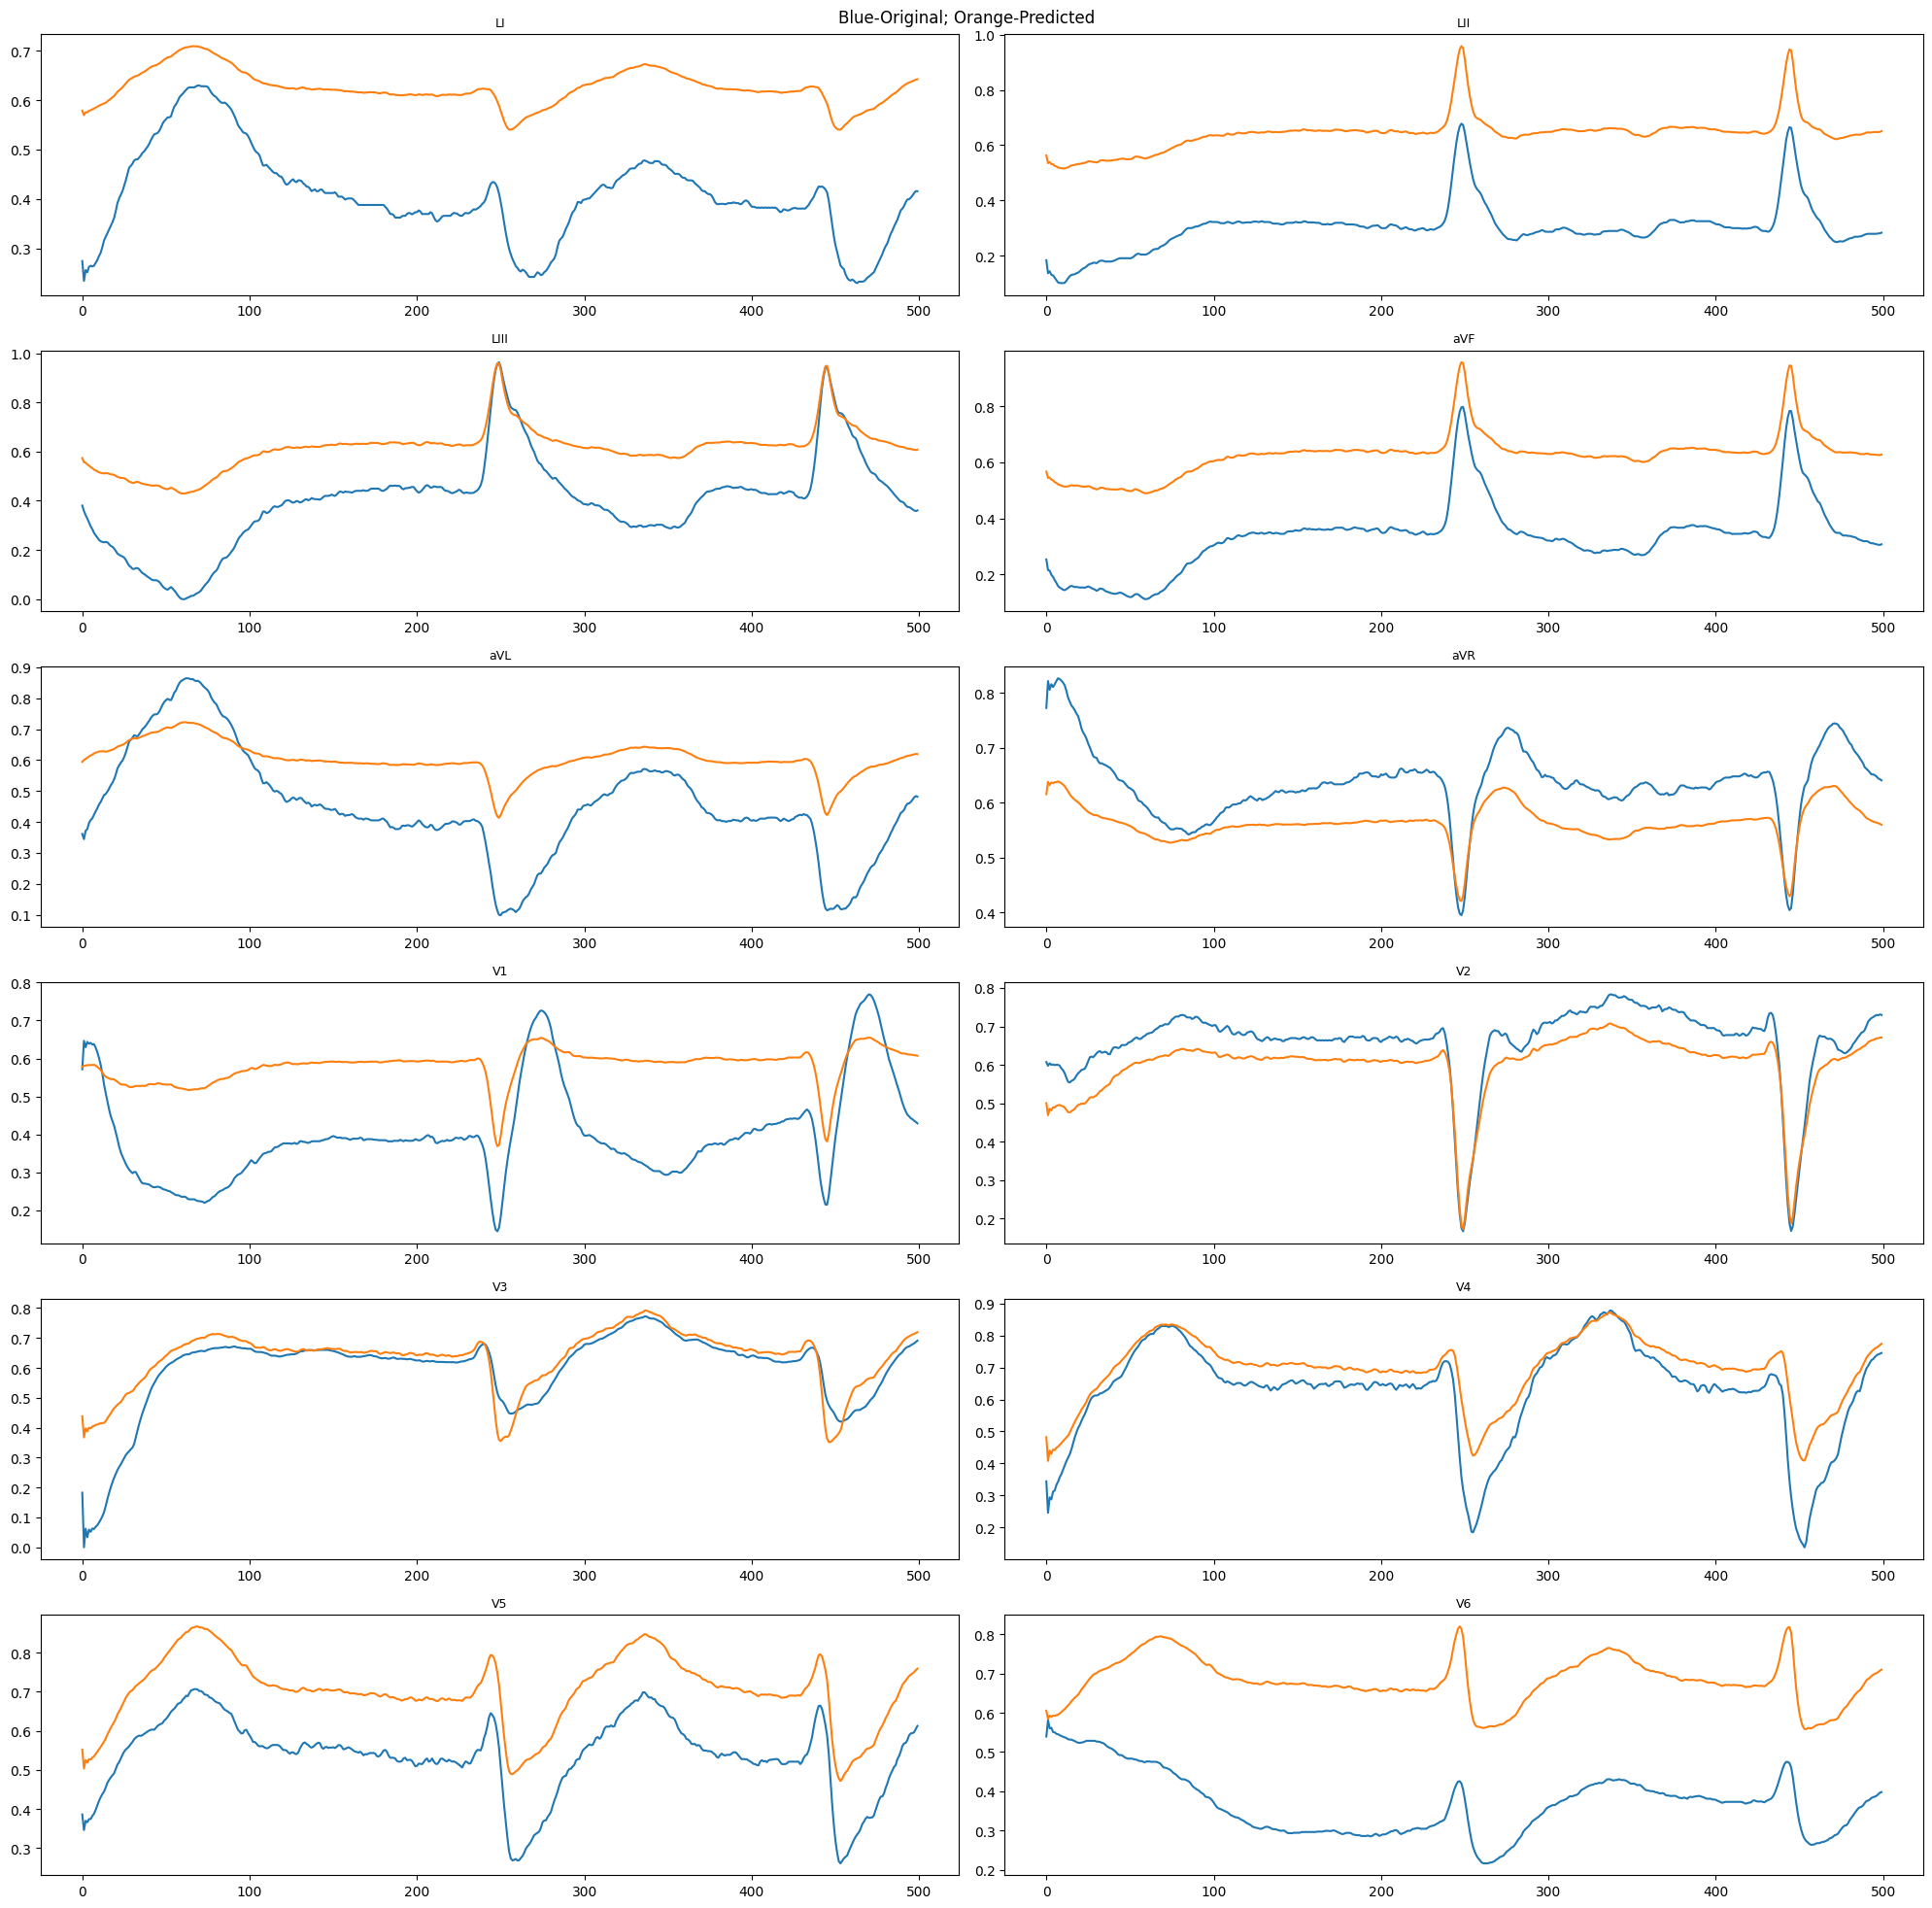

Plotting Imputation for Reading Q0047


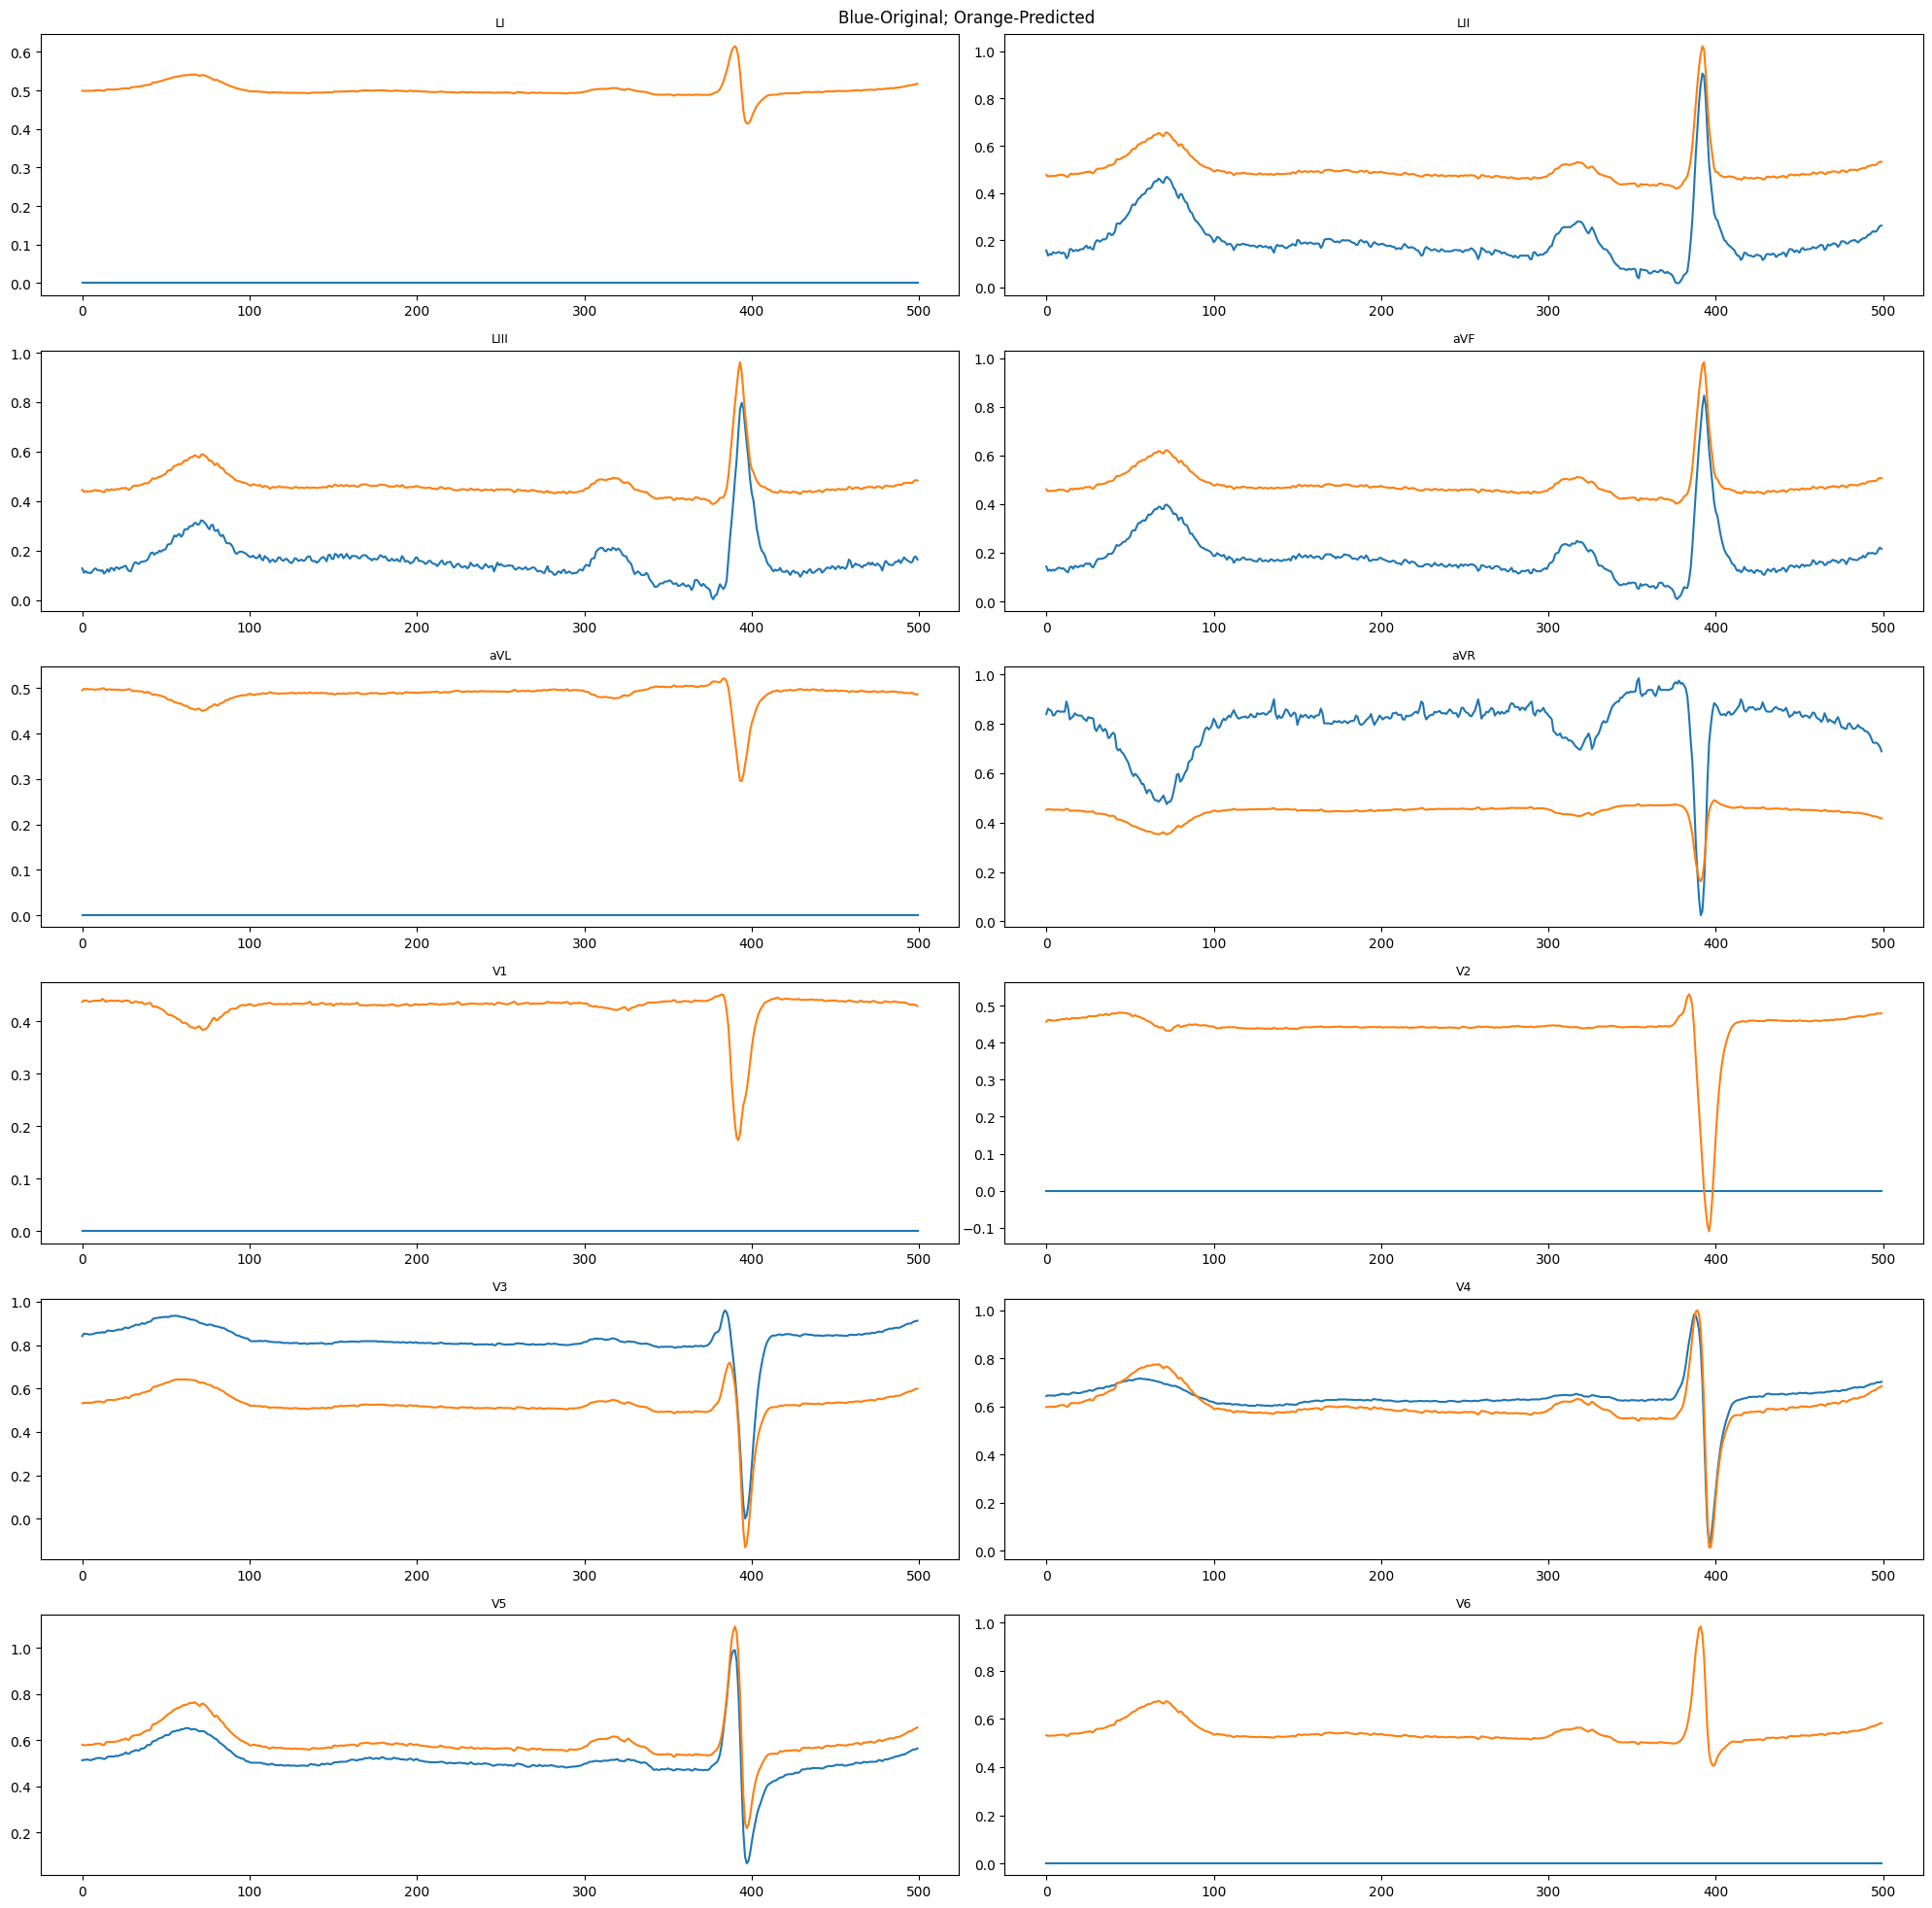

Plotting Imputation for Reading Q0649


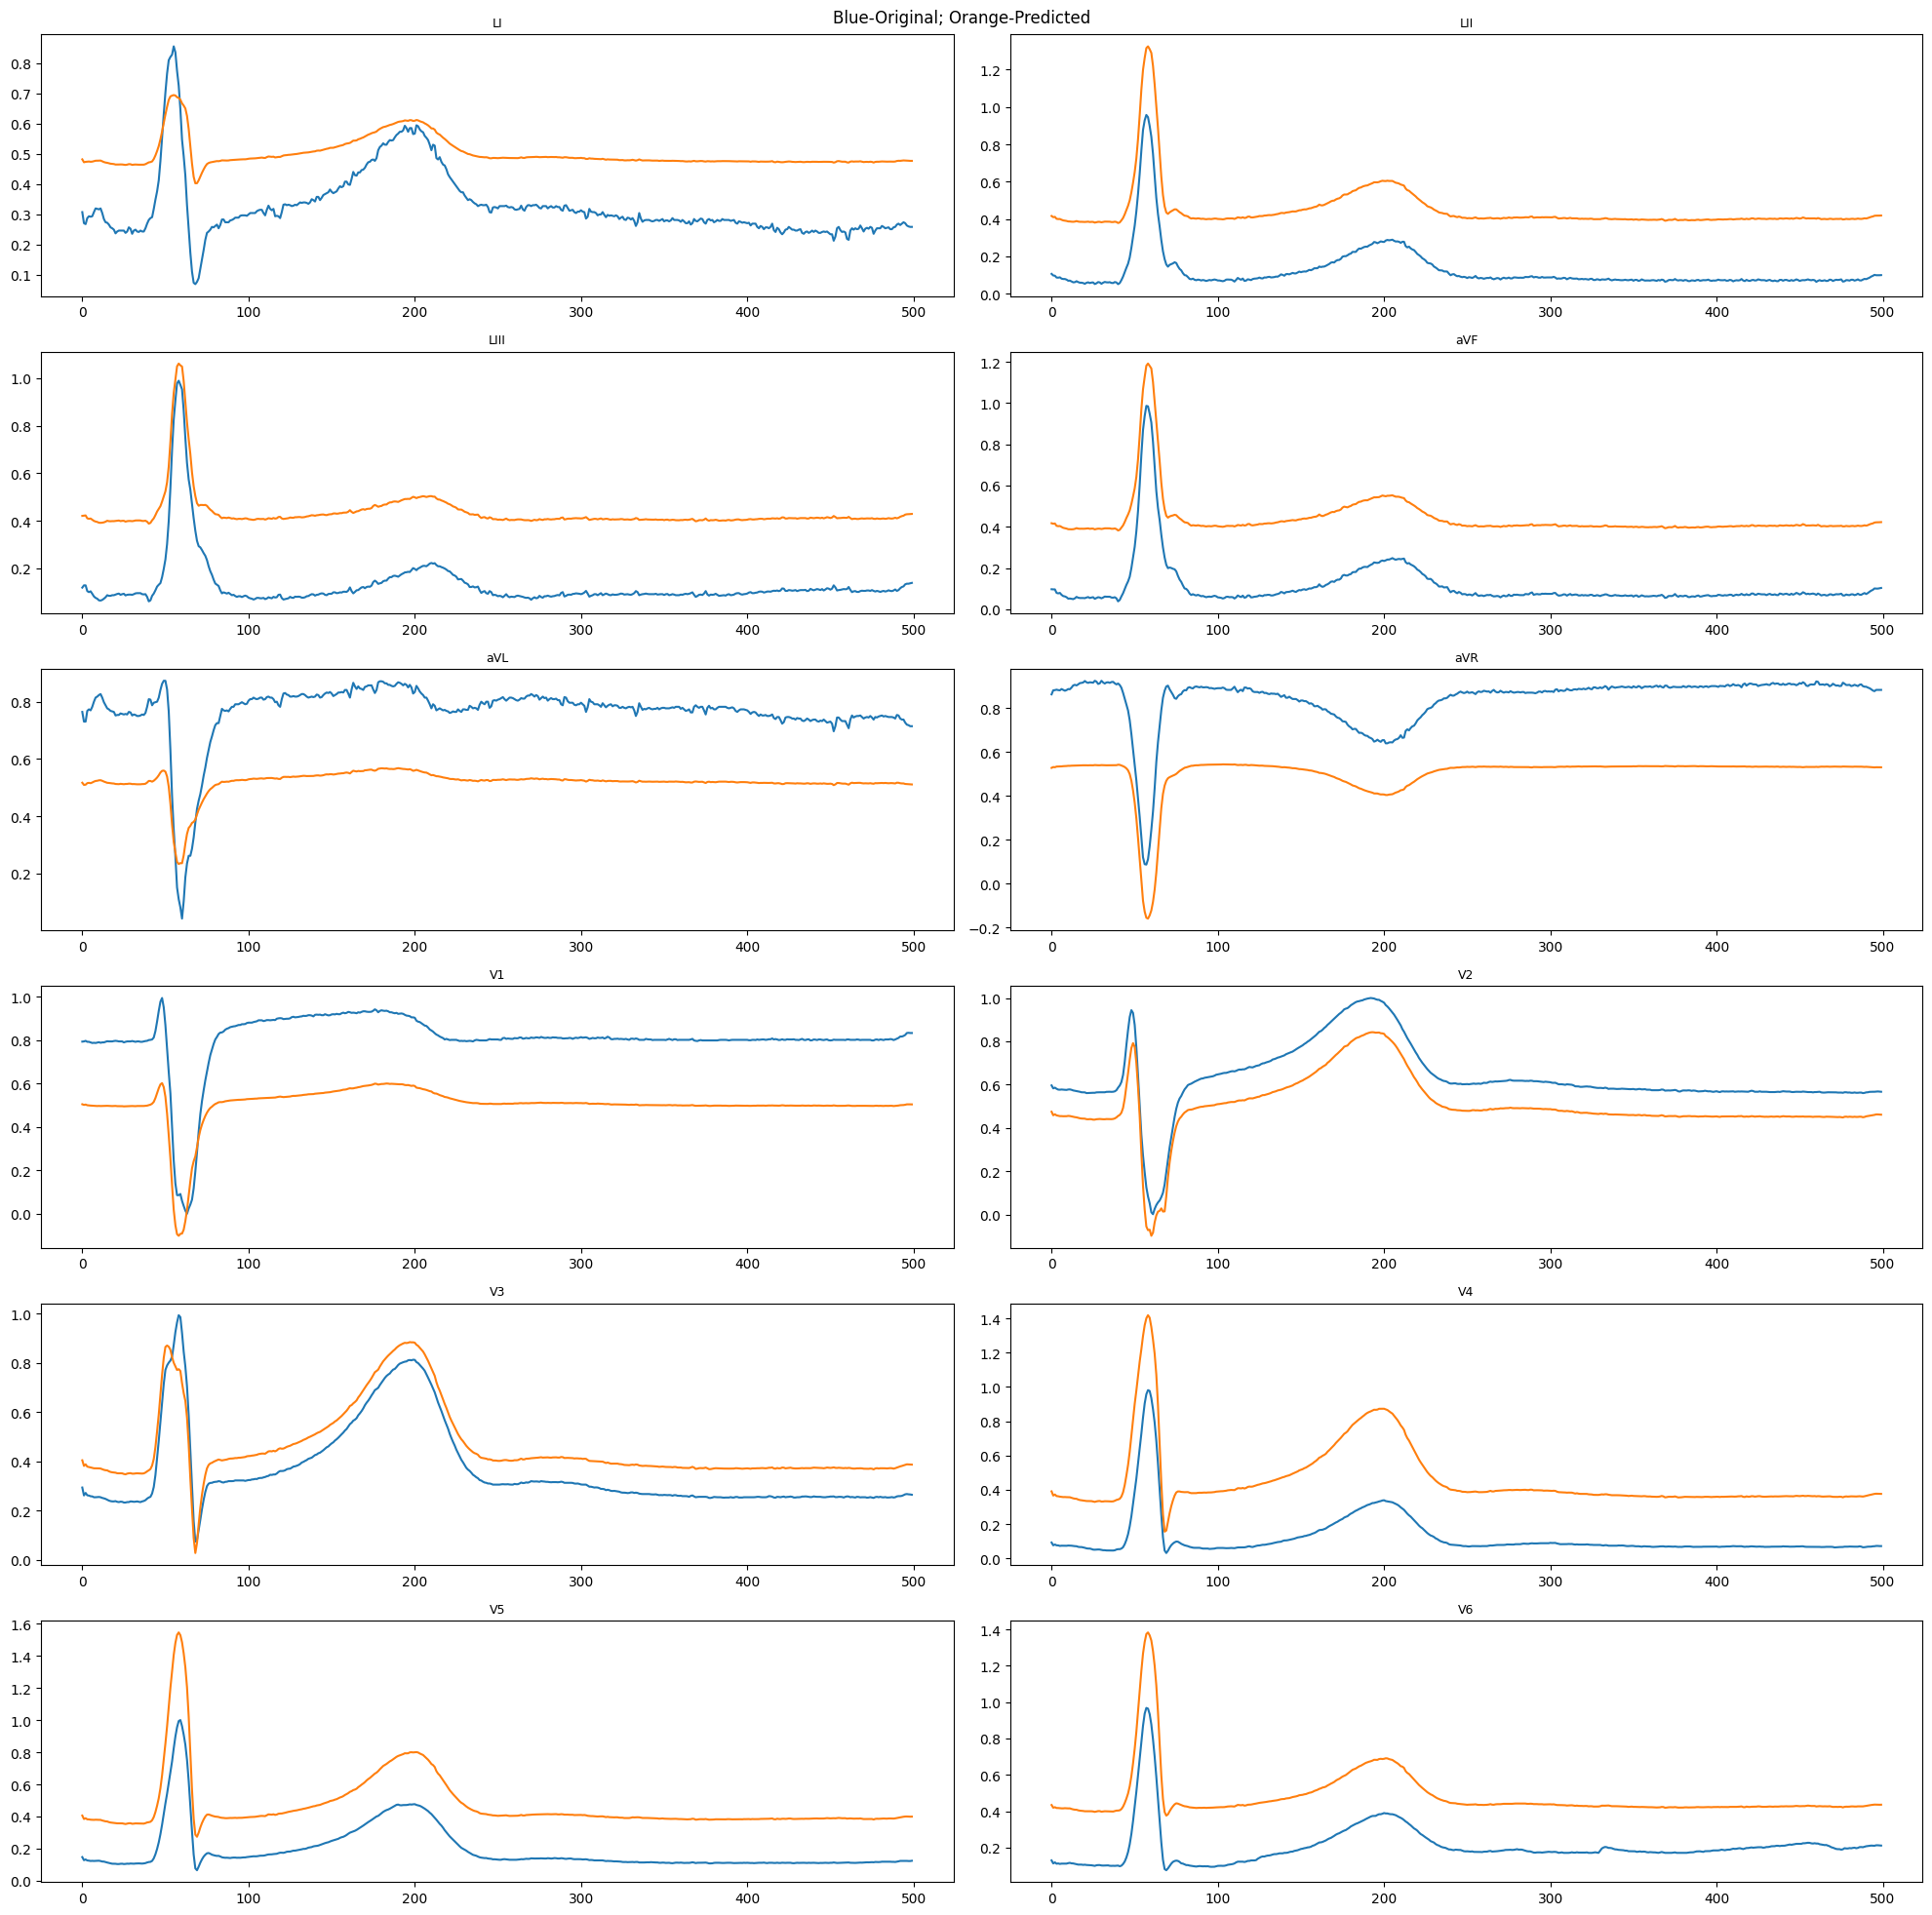

Plotting Imputation for Reading Q1777


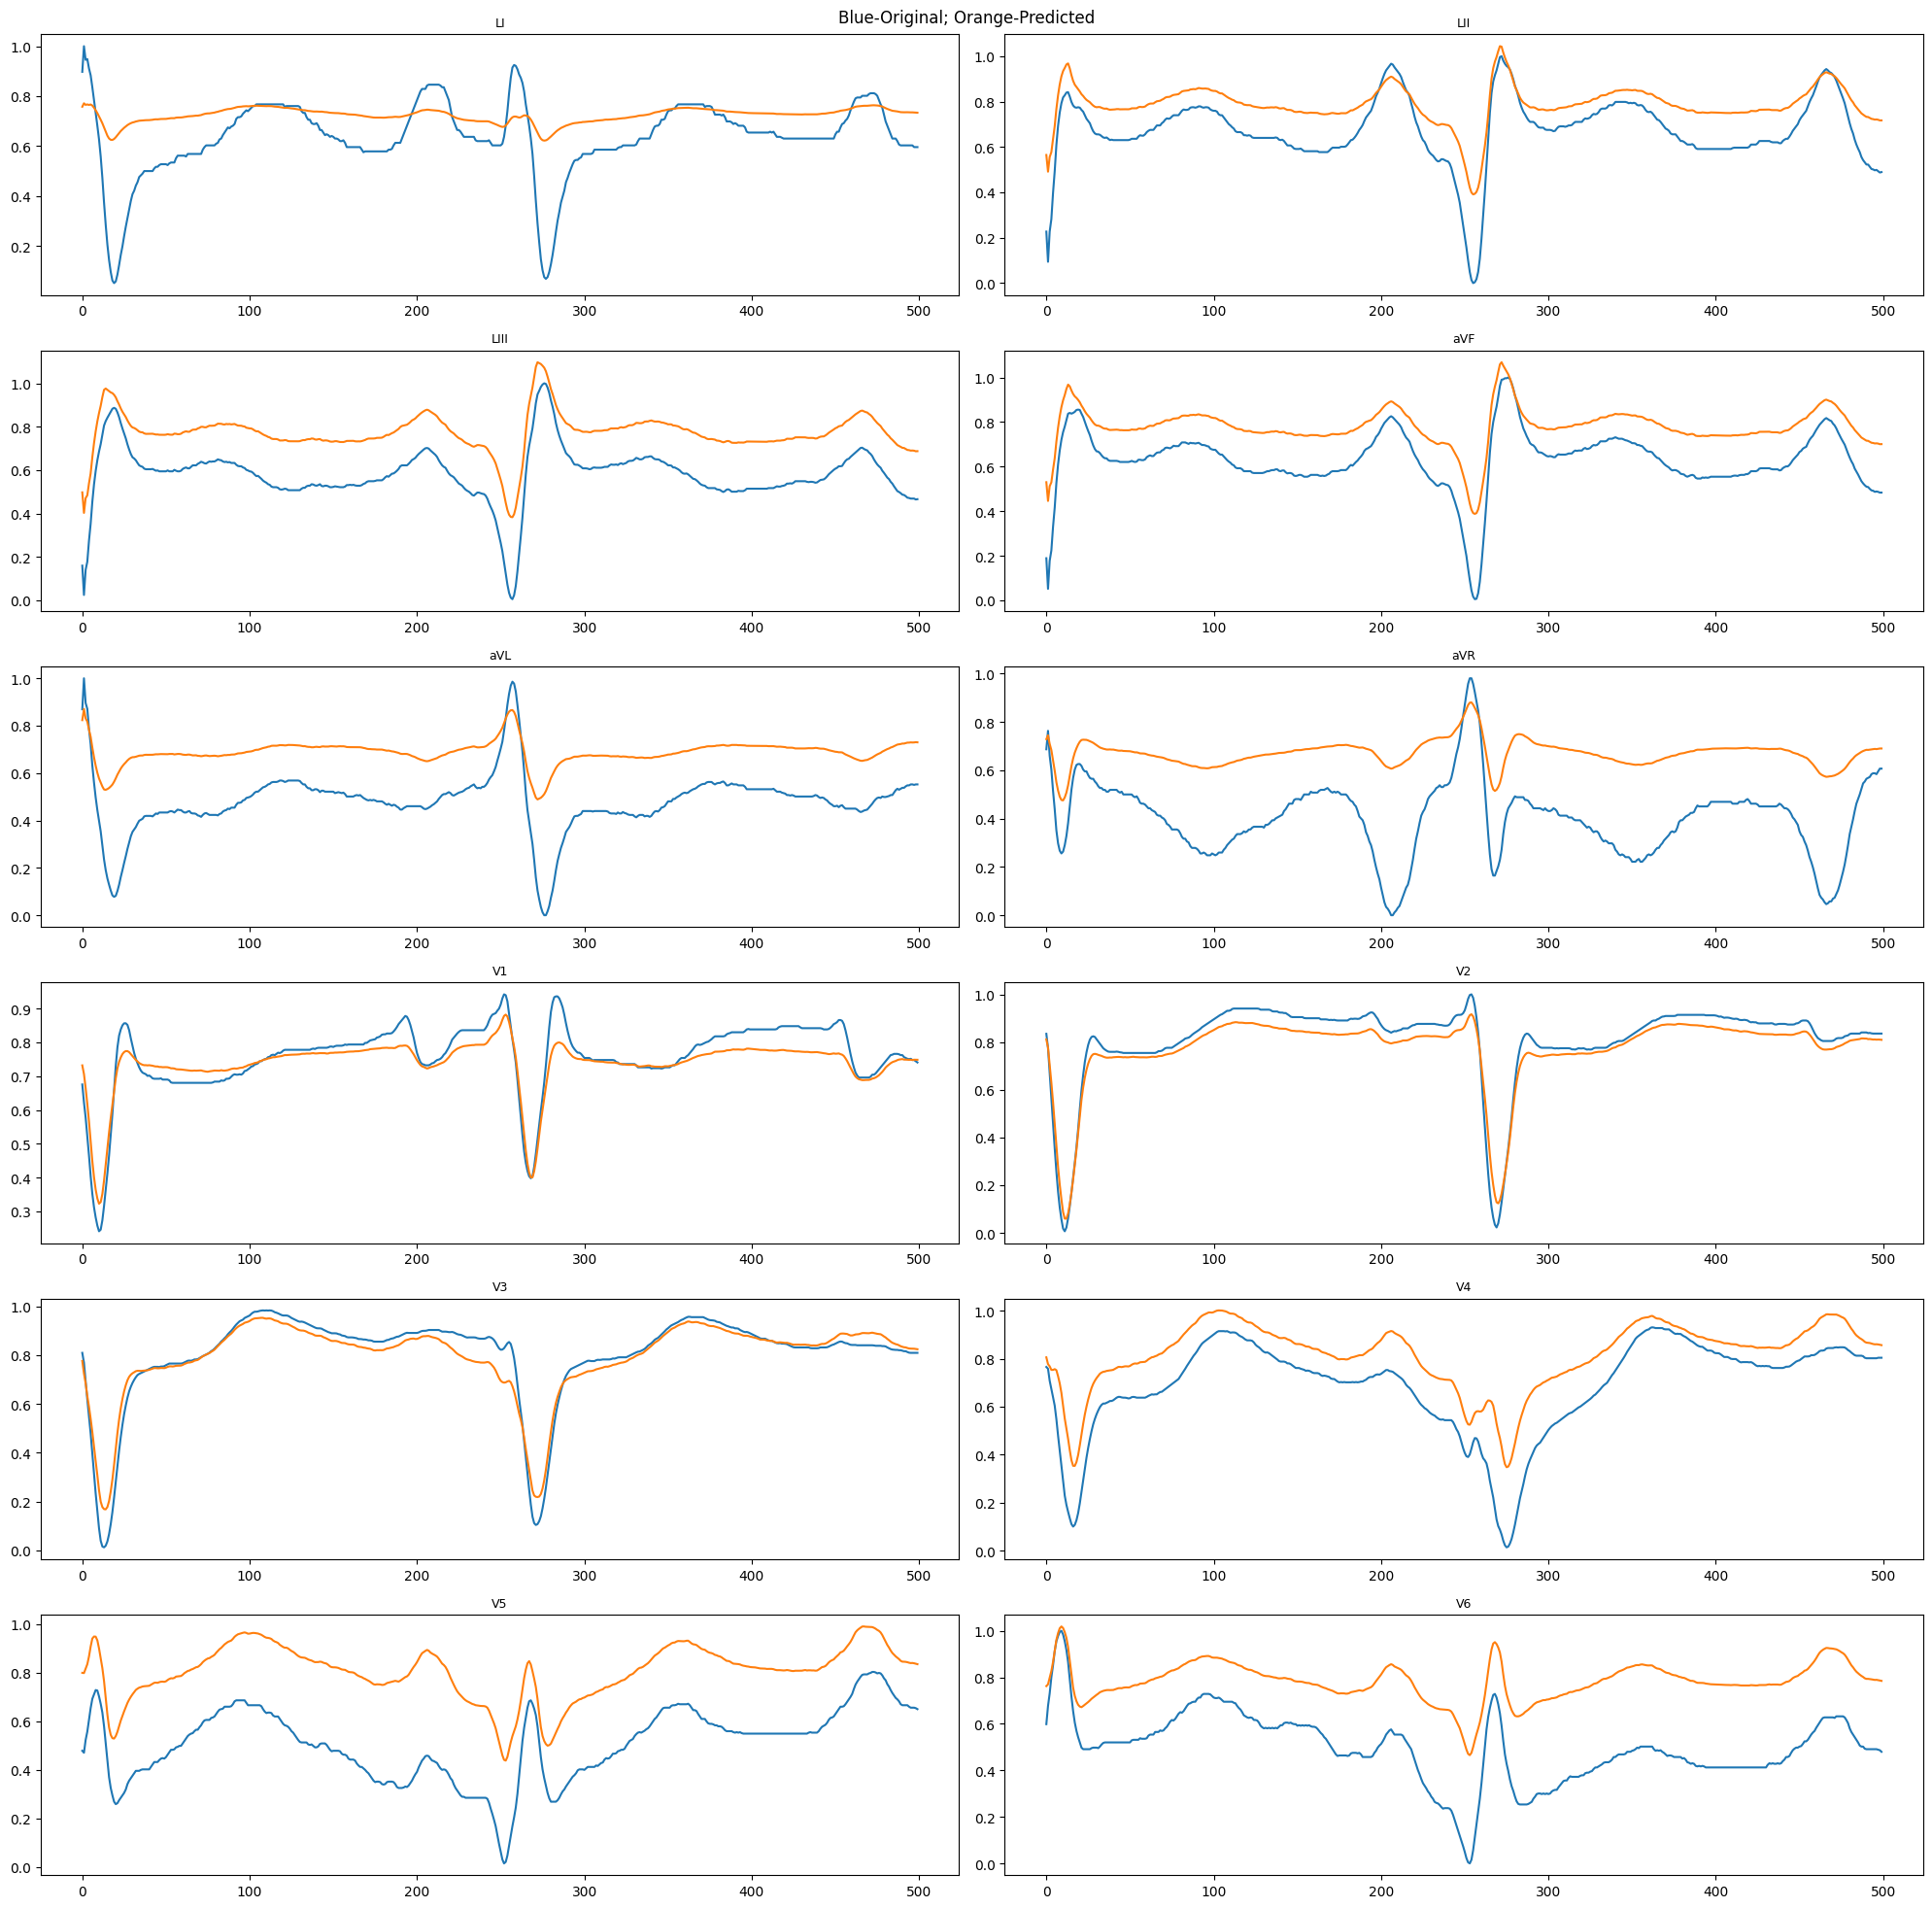

Plotting Imputation for Reading Q1823


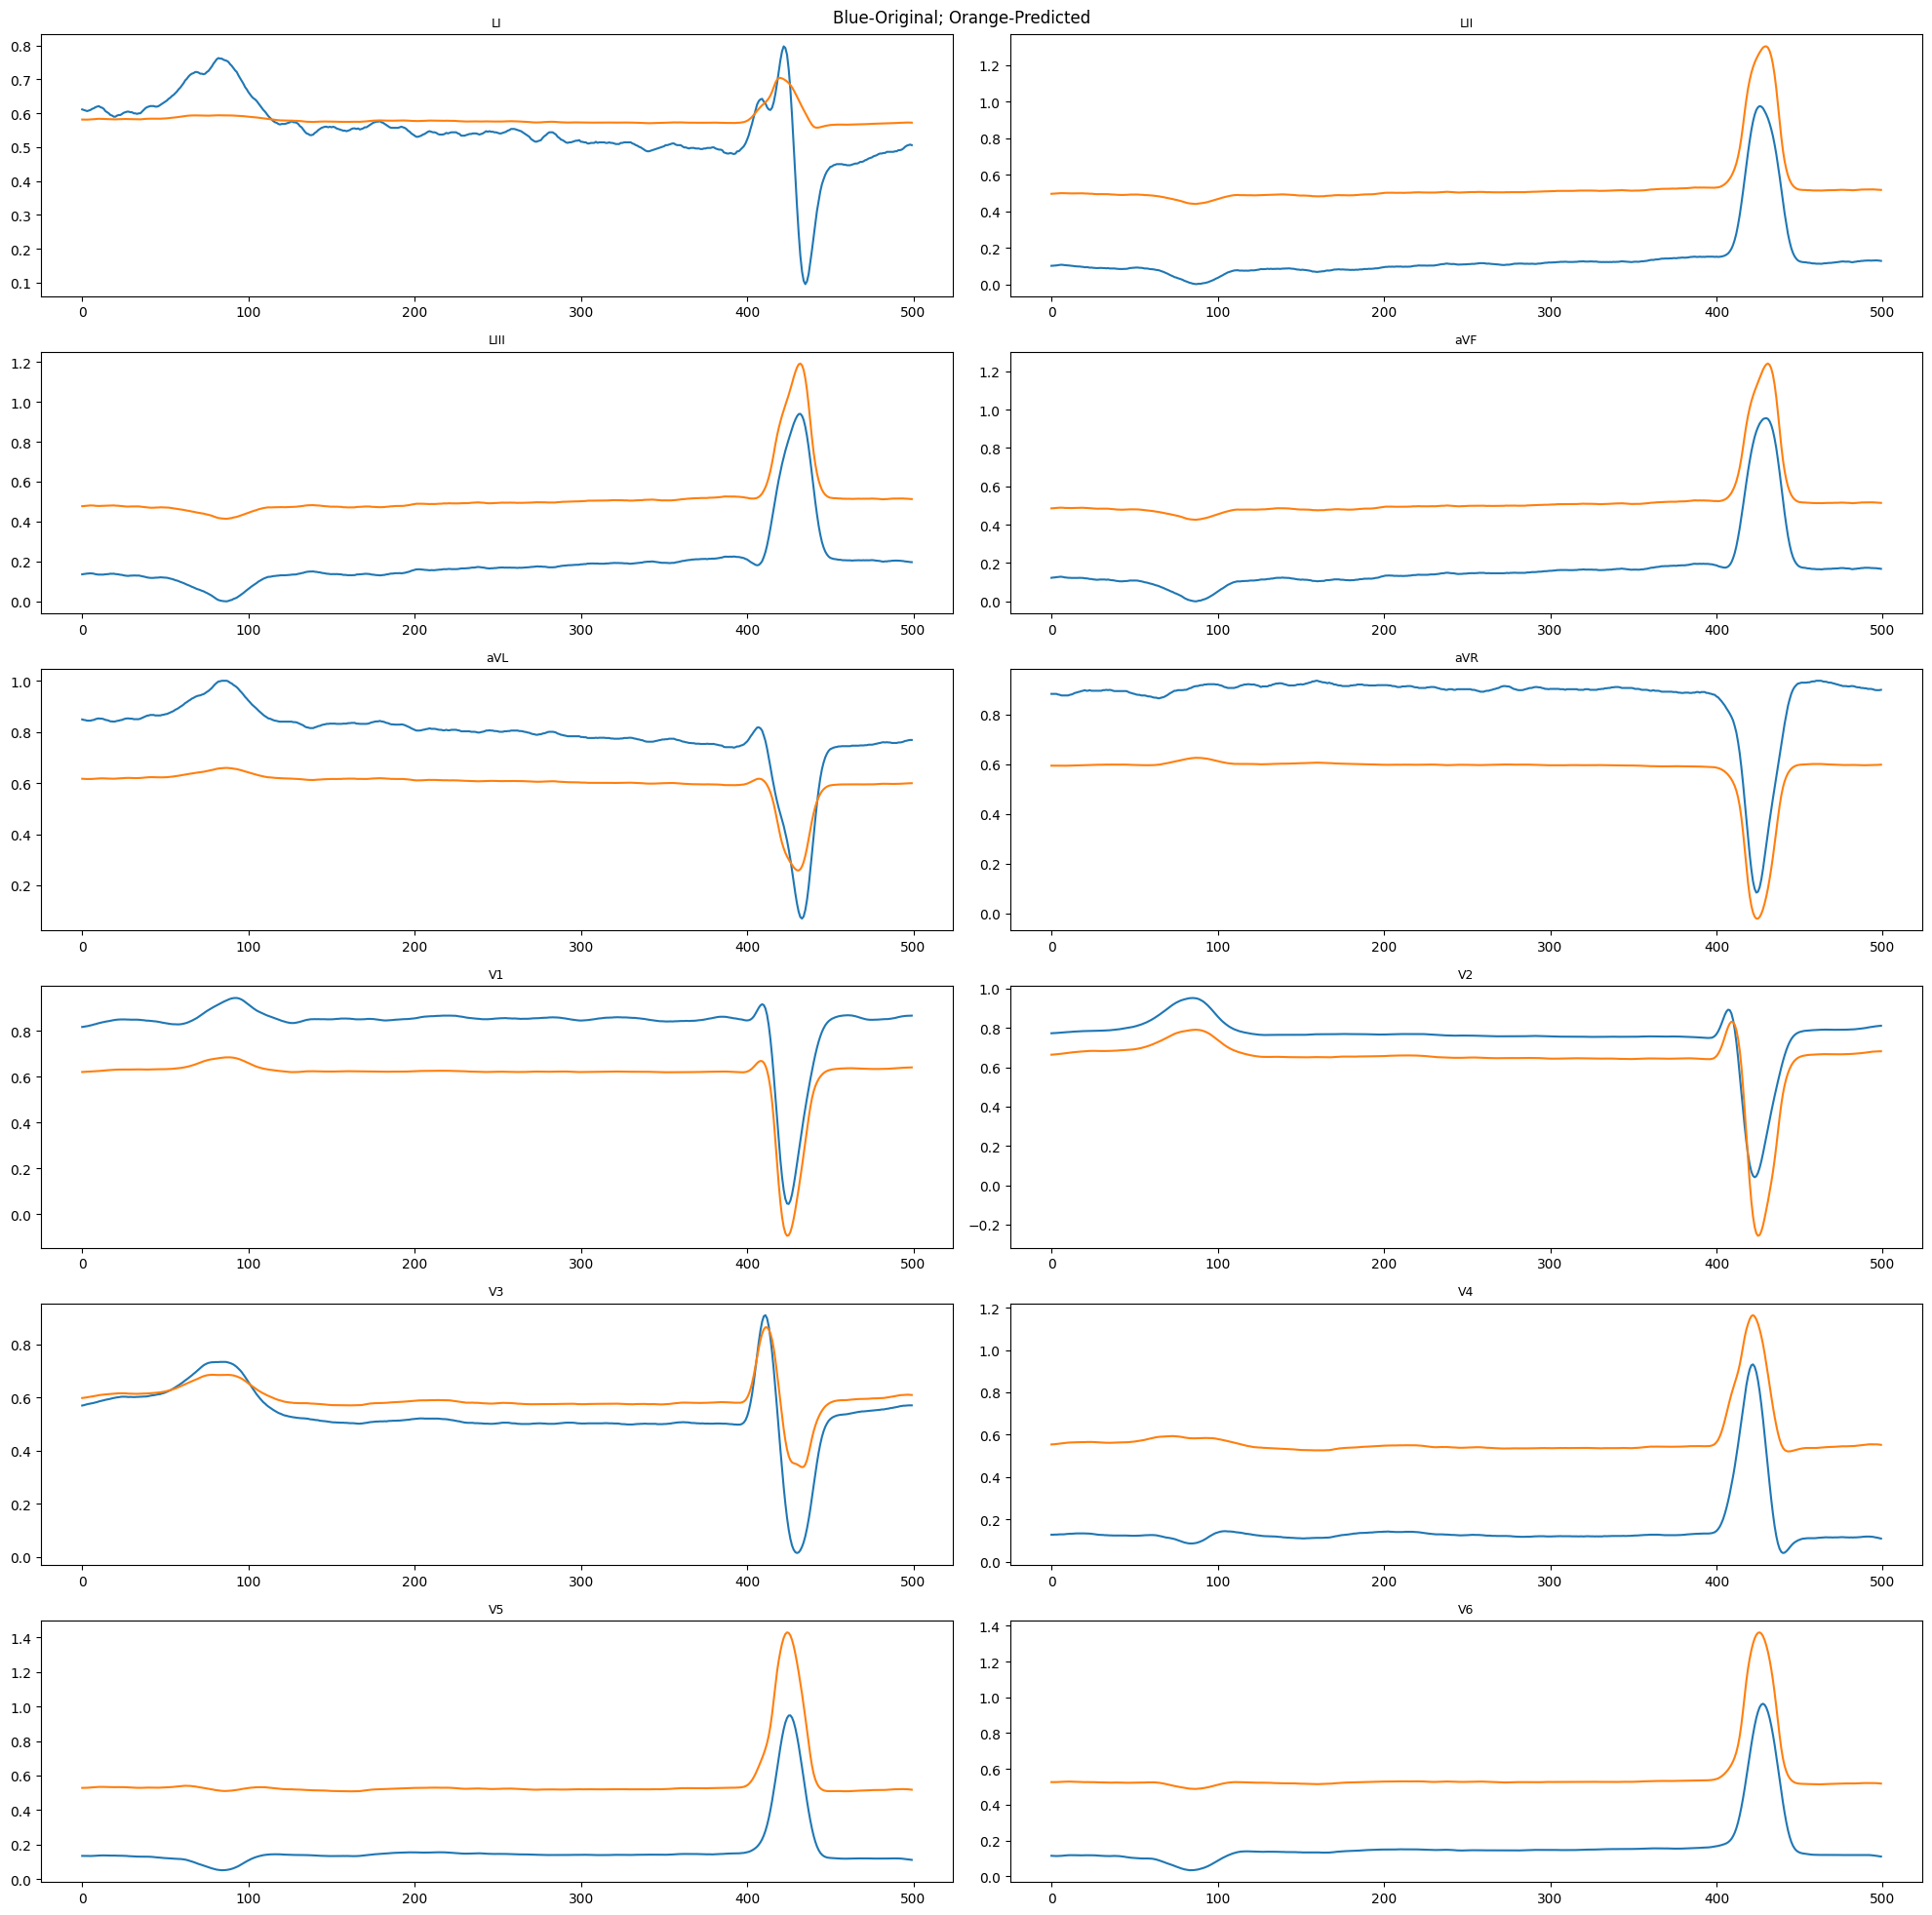

Plotting Imputation for Reading Q3098


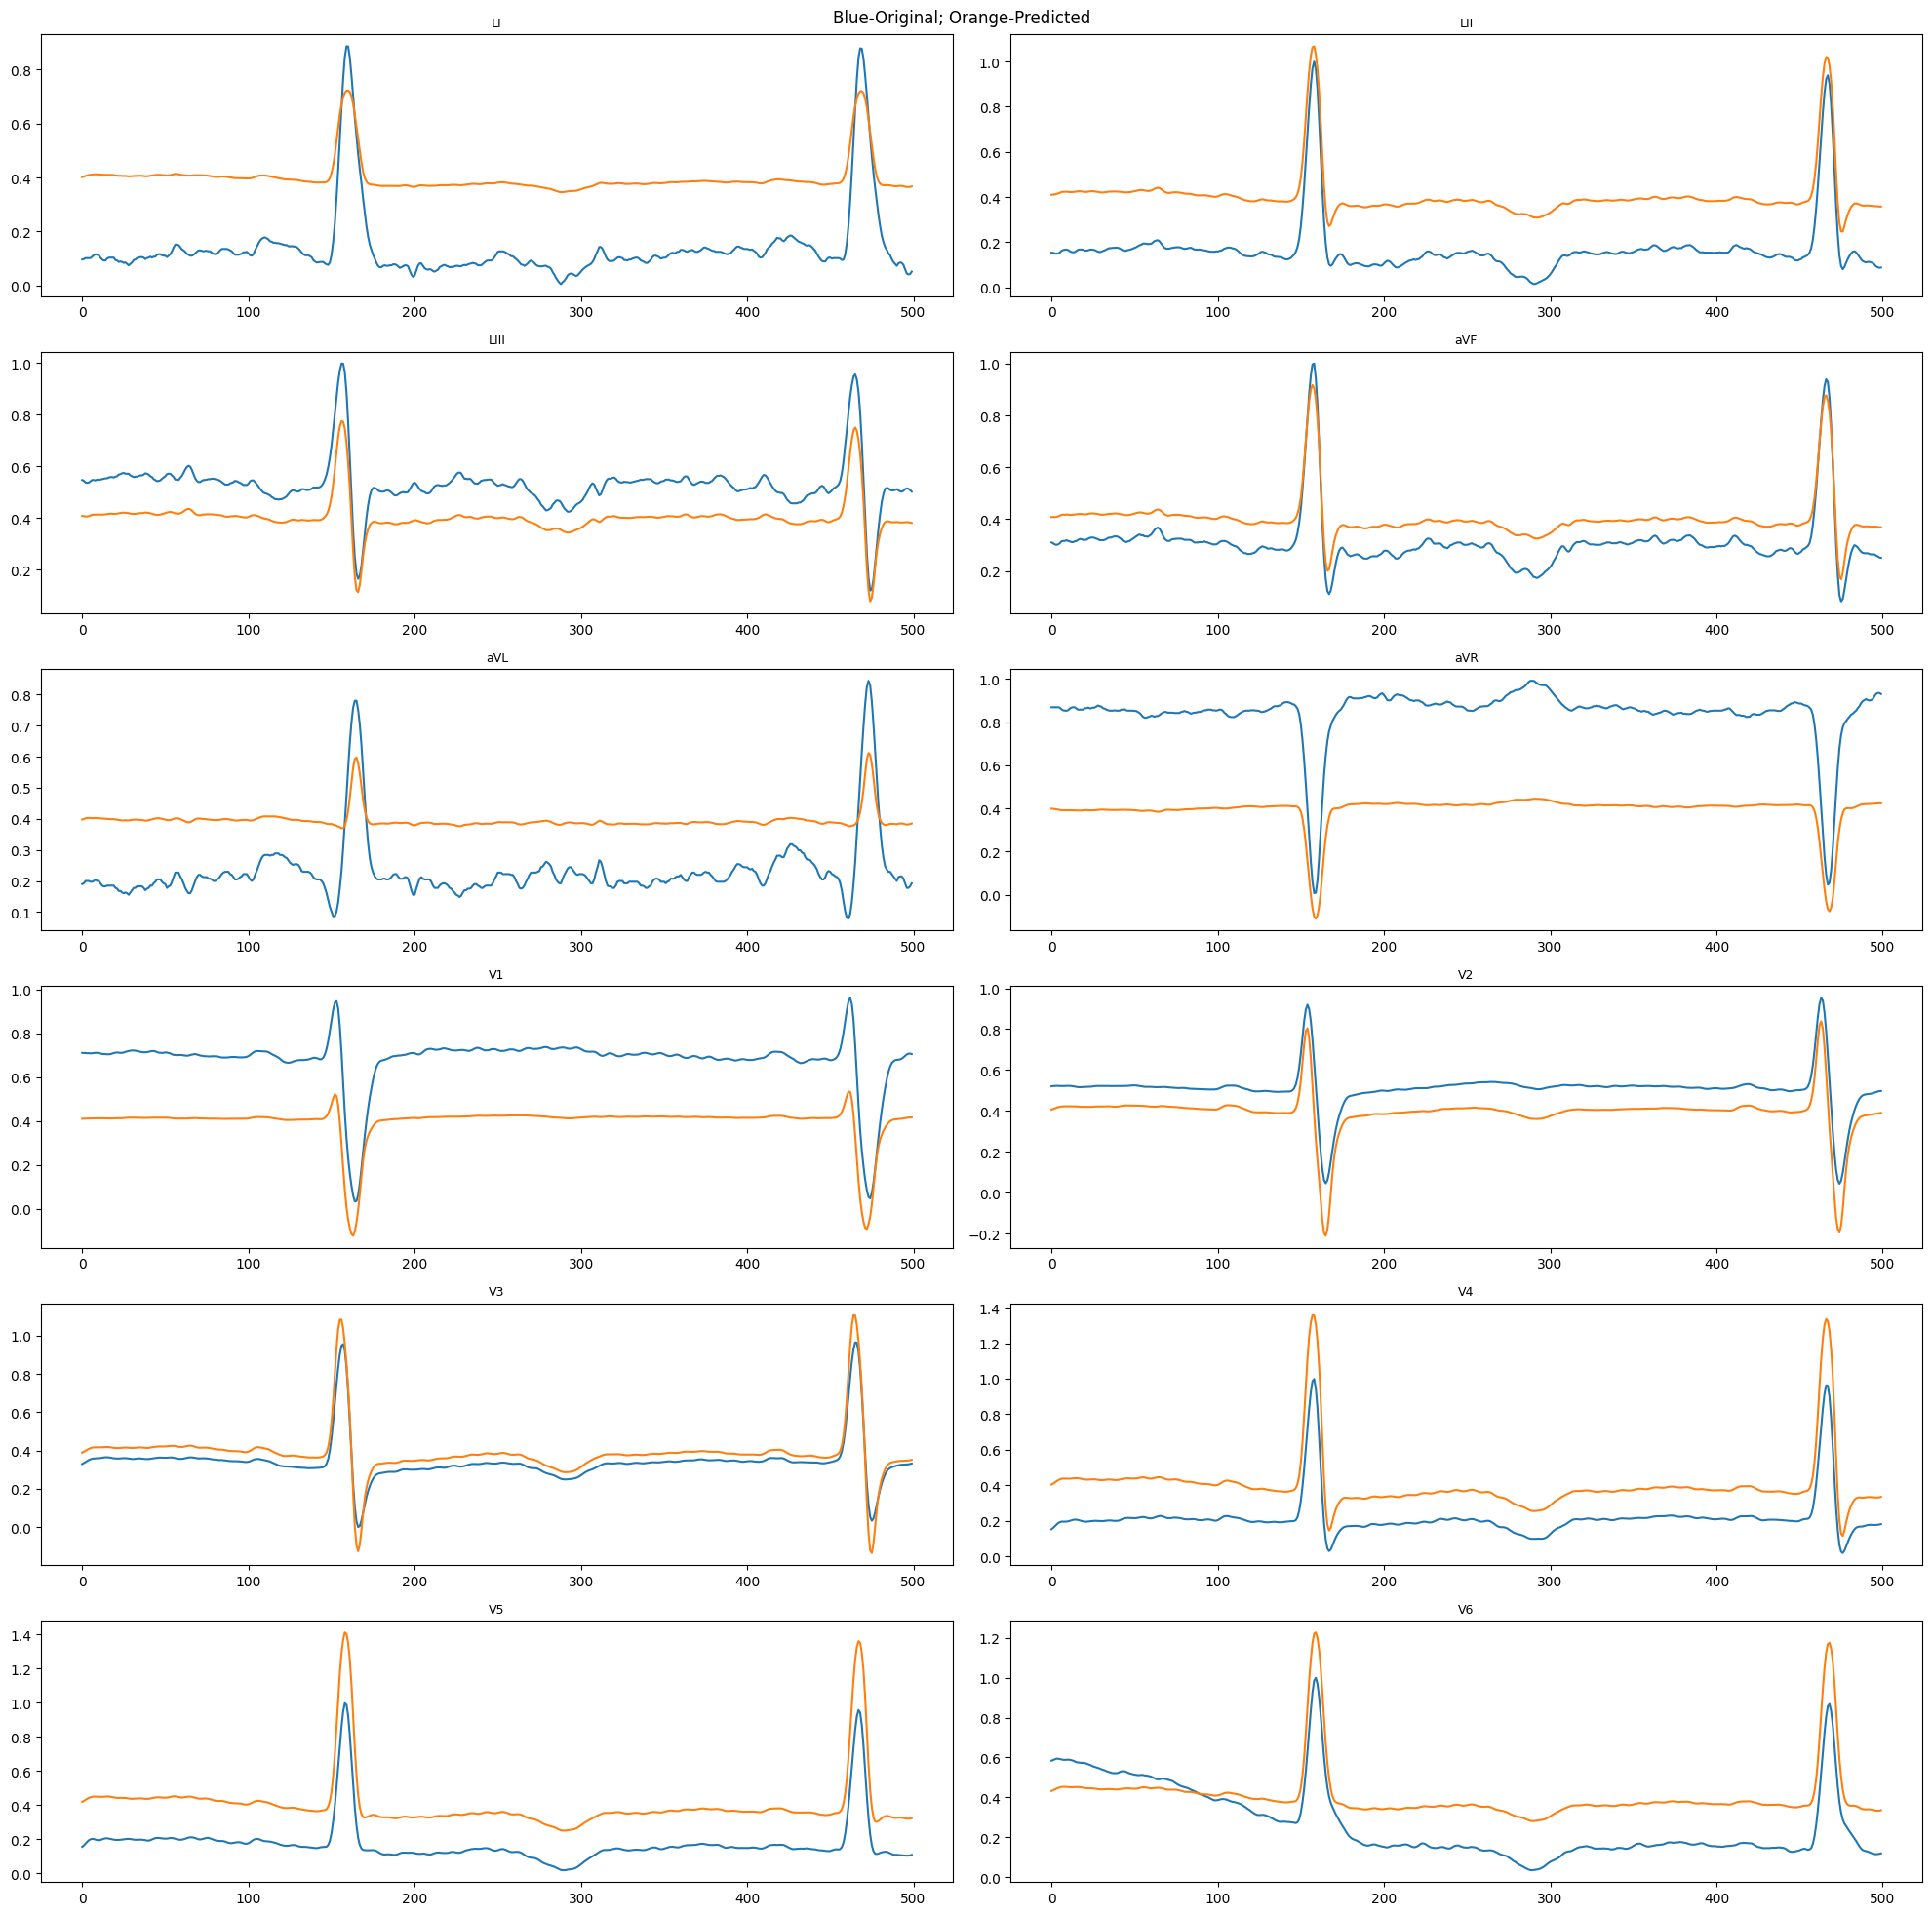

Plotting Imputation for Reading Q0978


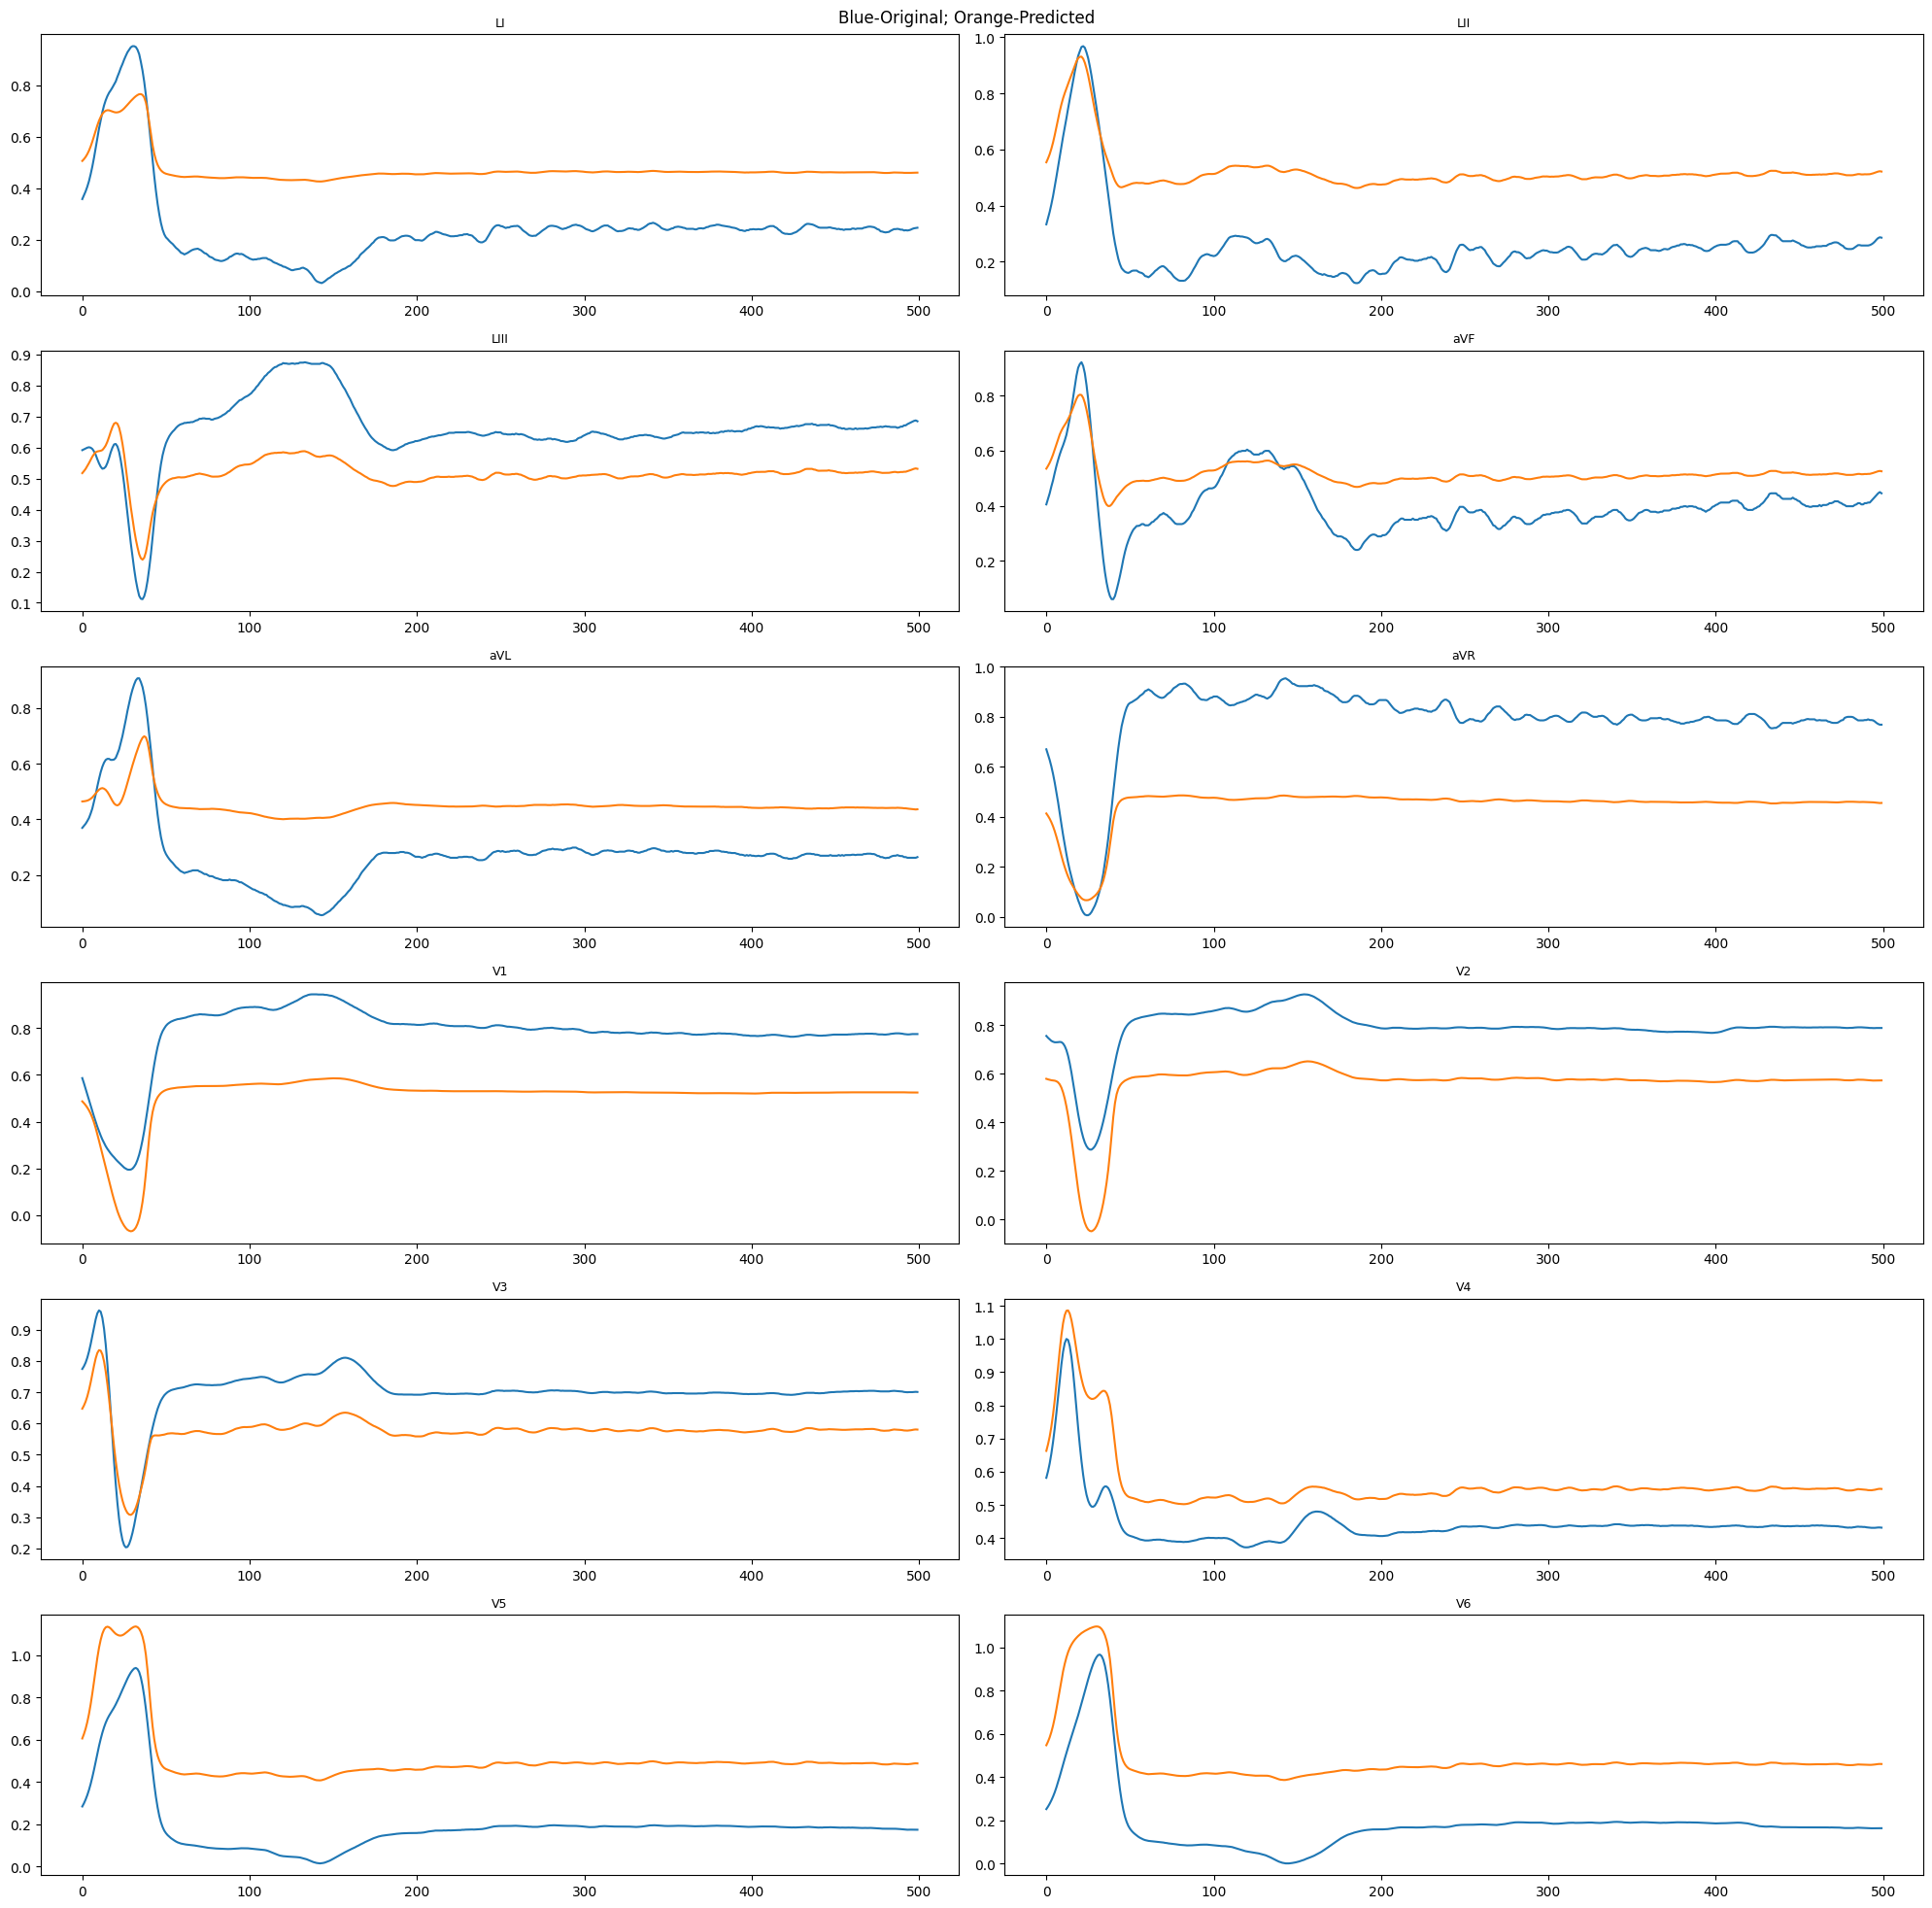

Plotting Imputation for Reading Q3159


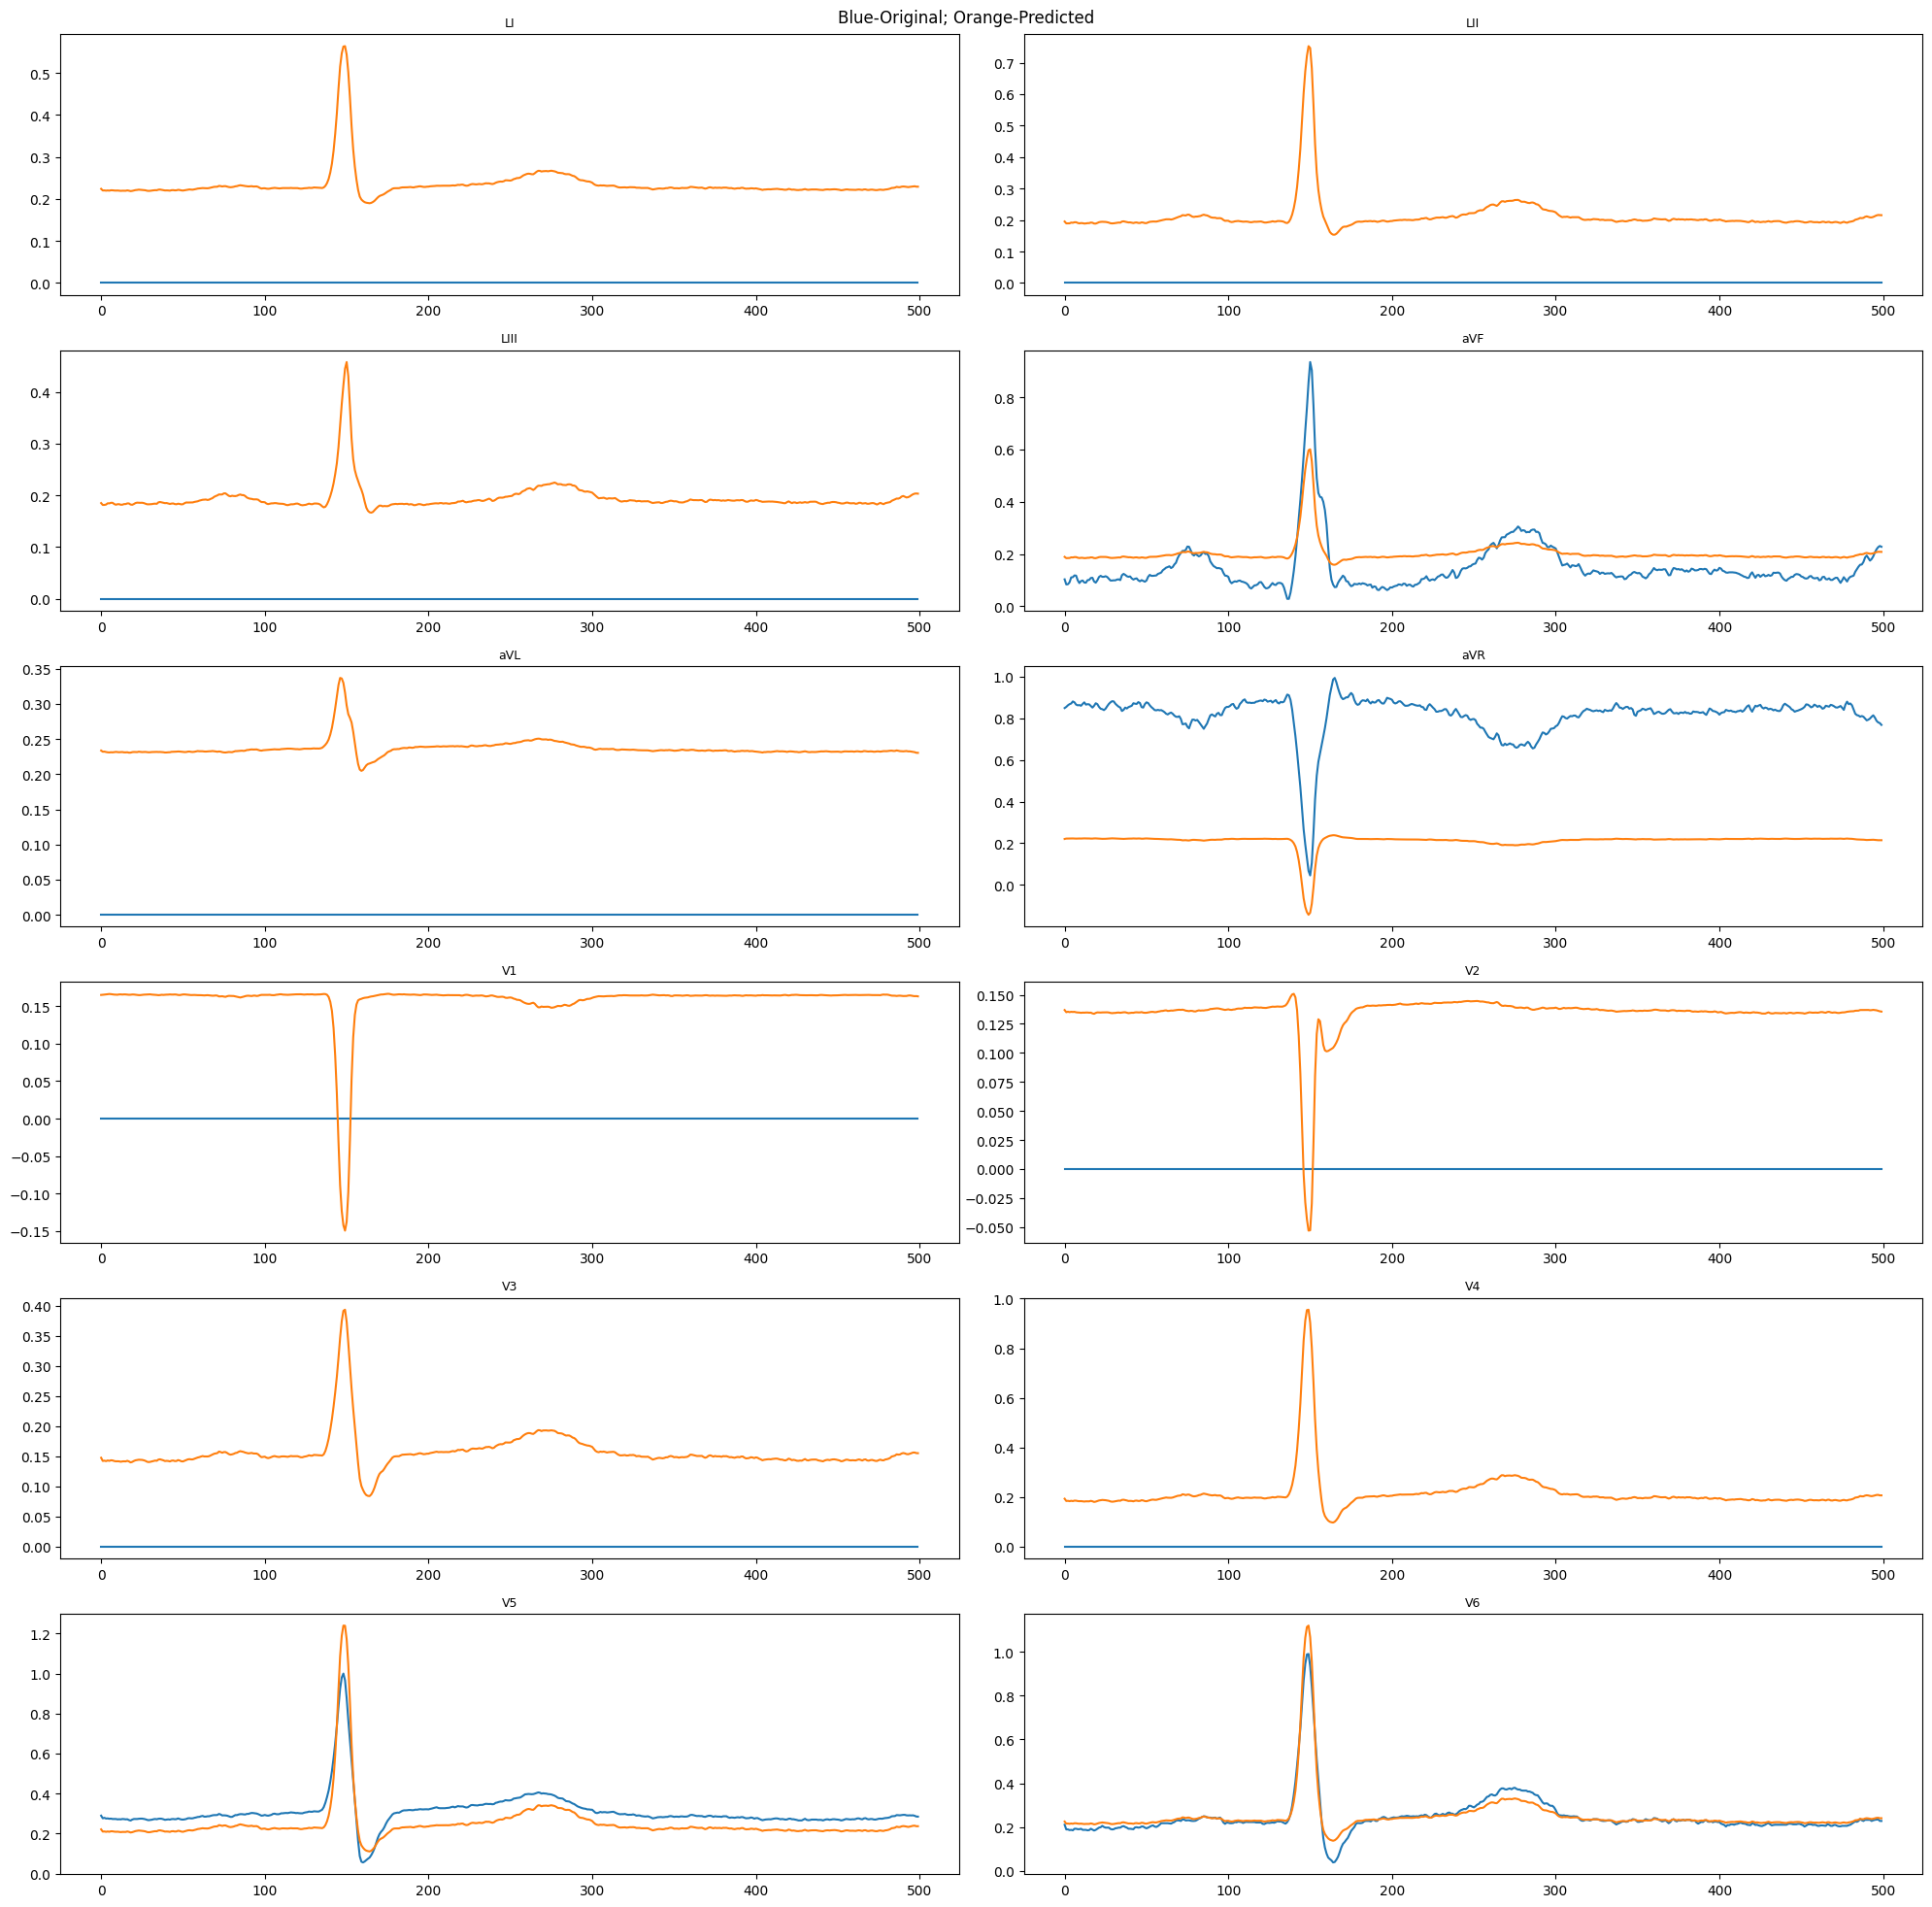

Plotting Imputation for Reading Q2079


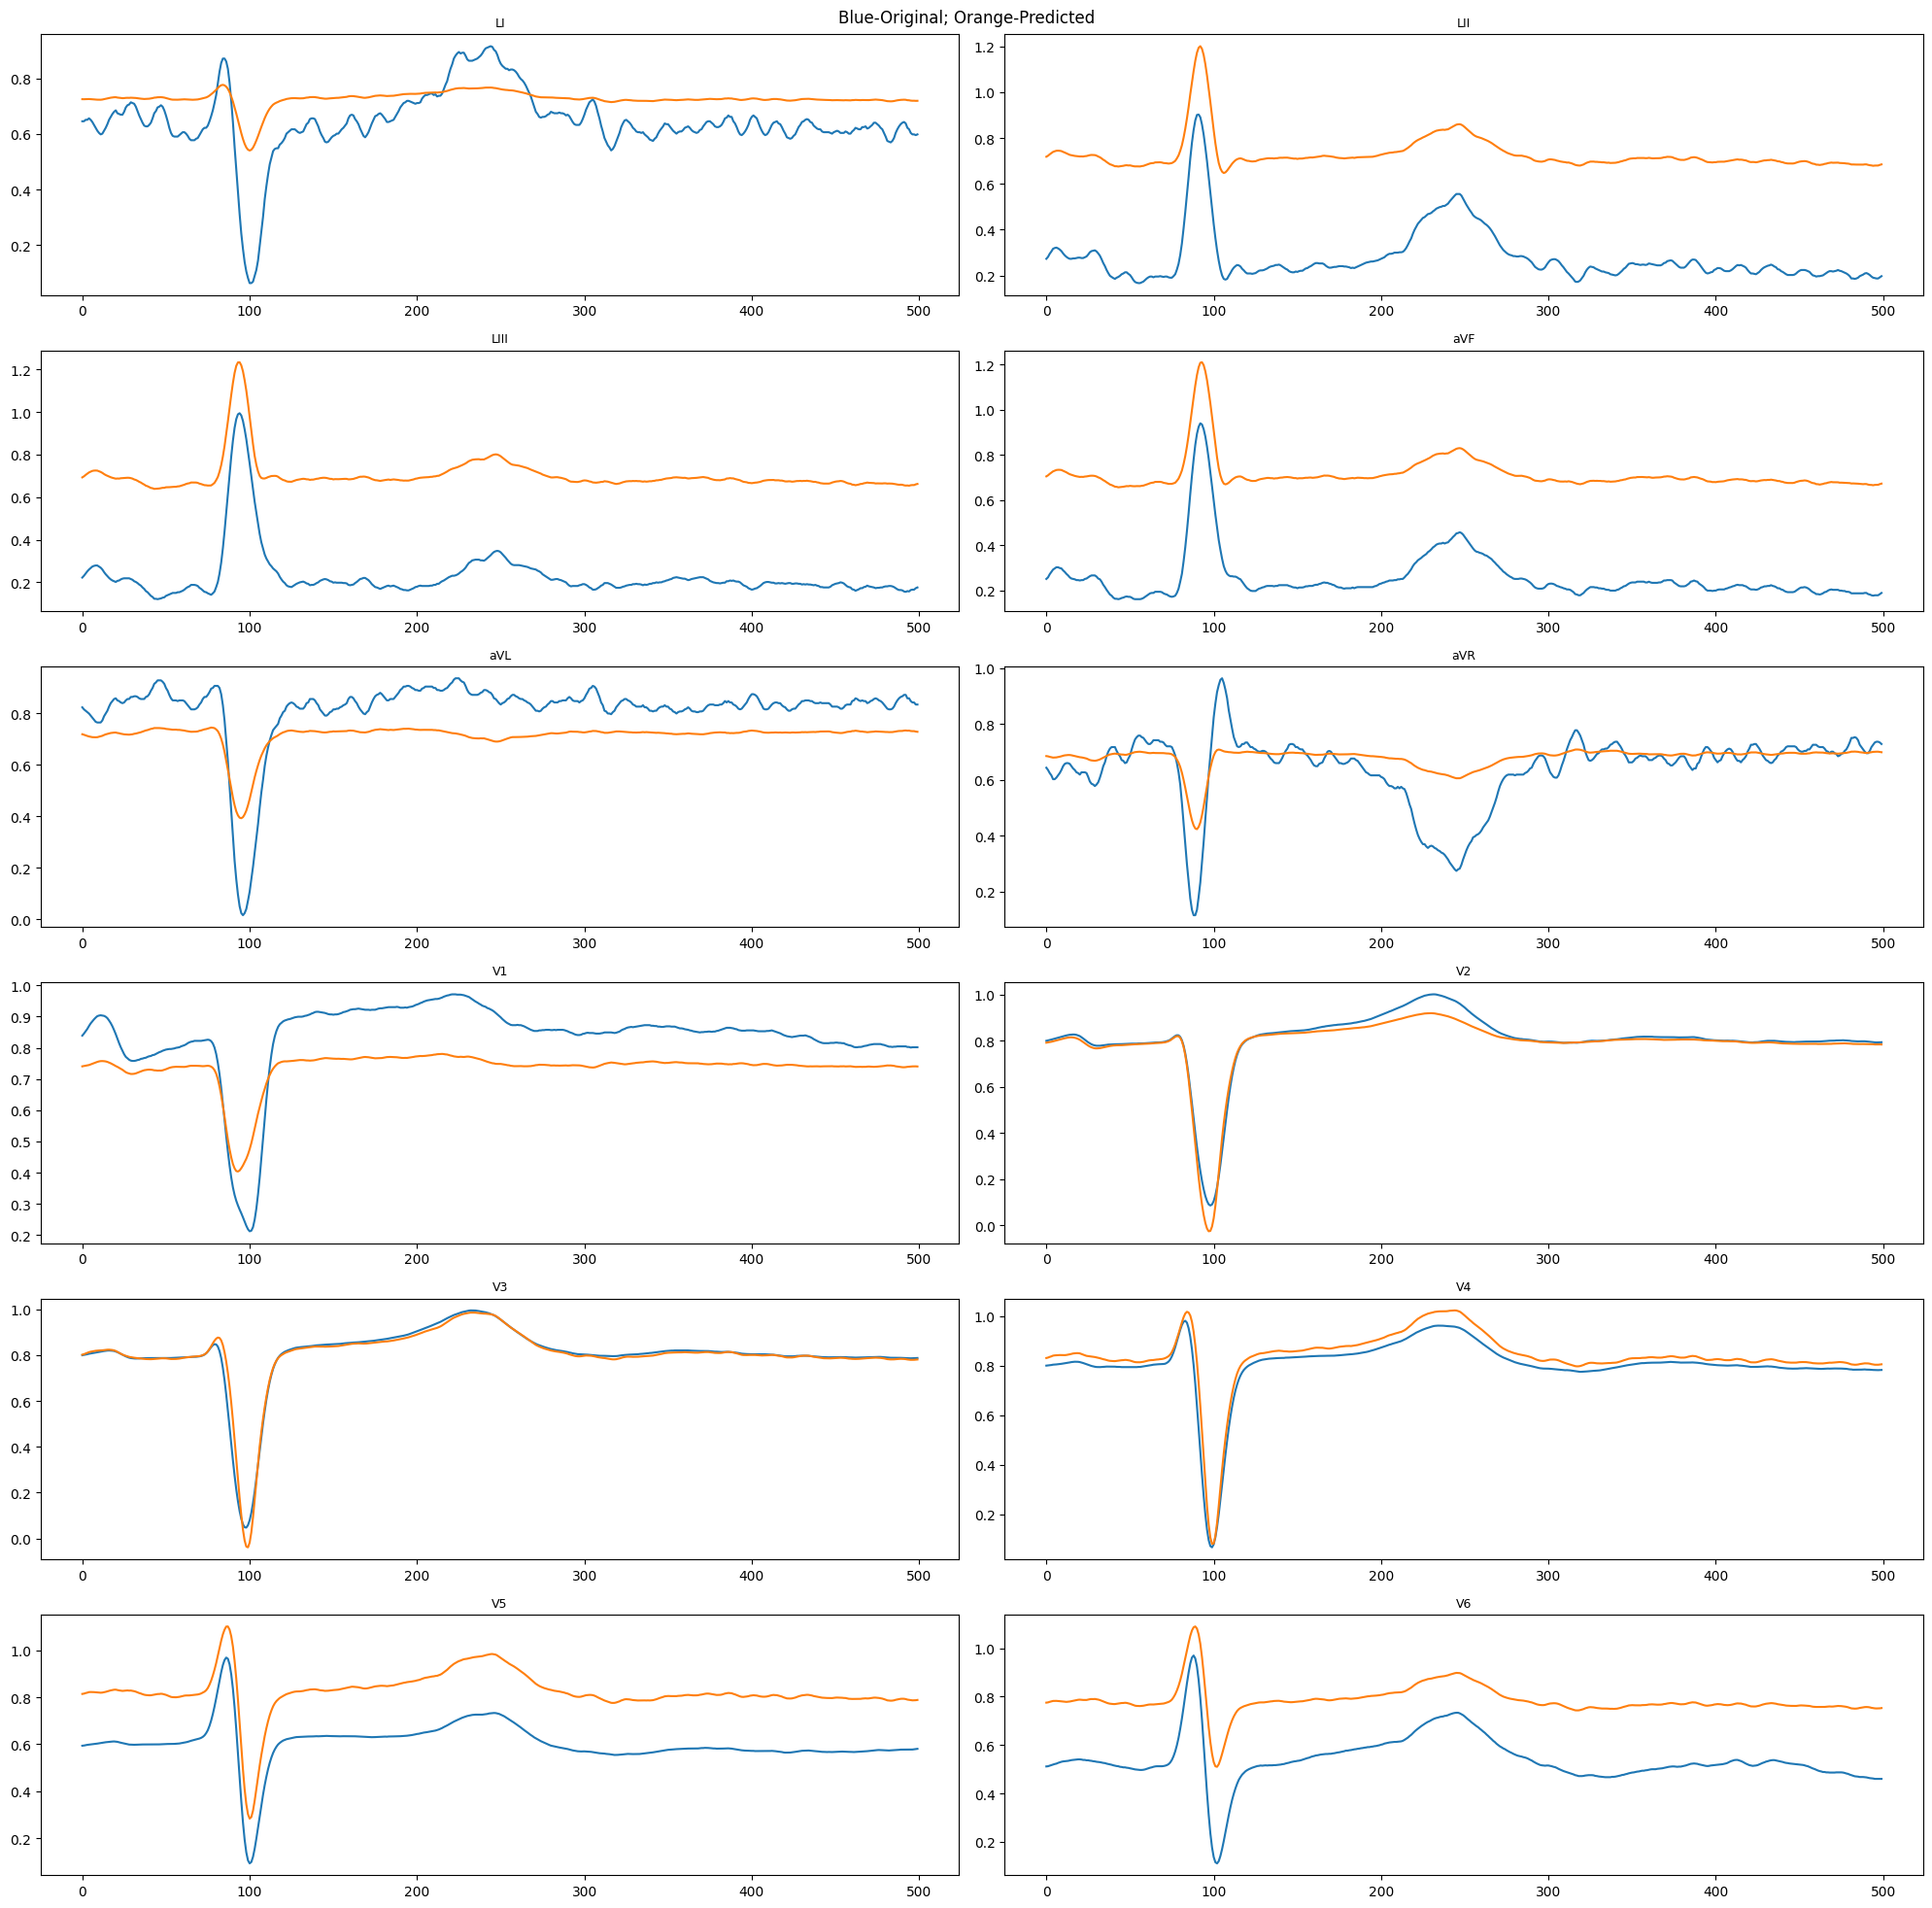

Plotting Imputation for Reading Q1702


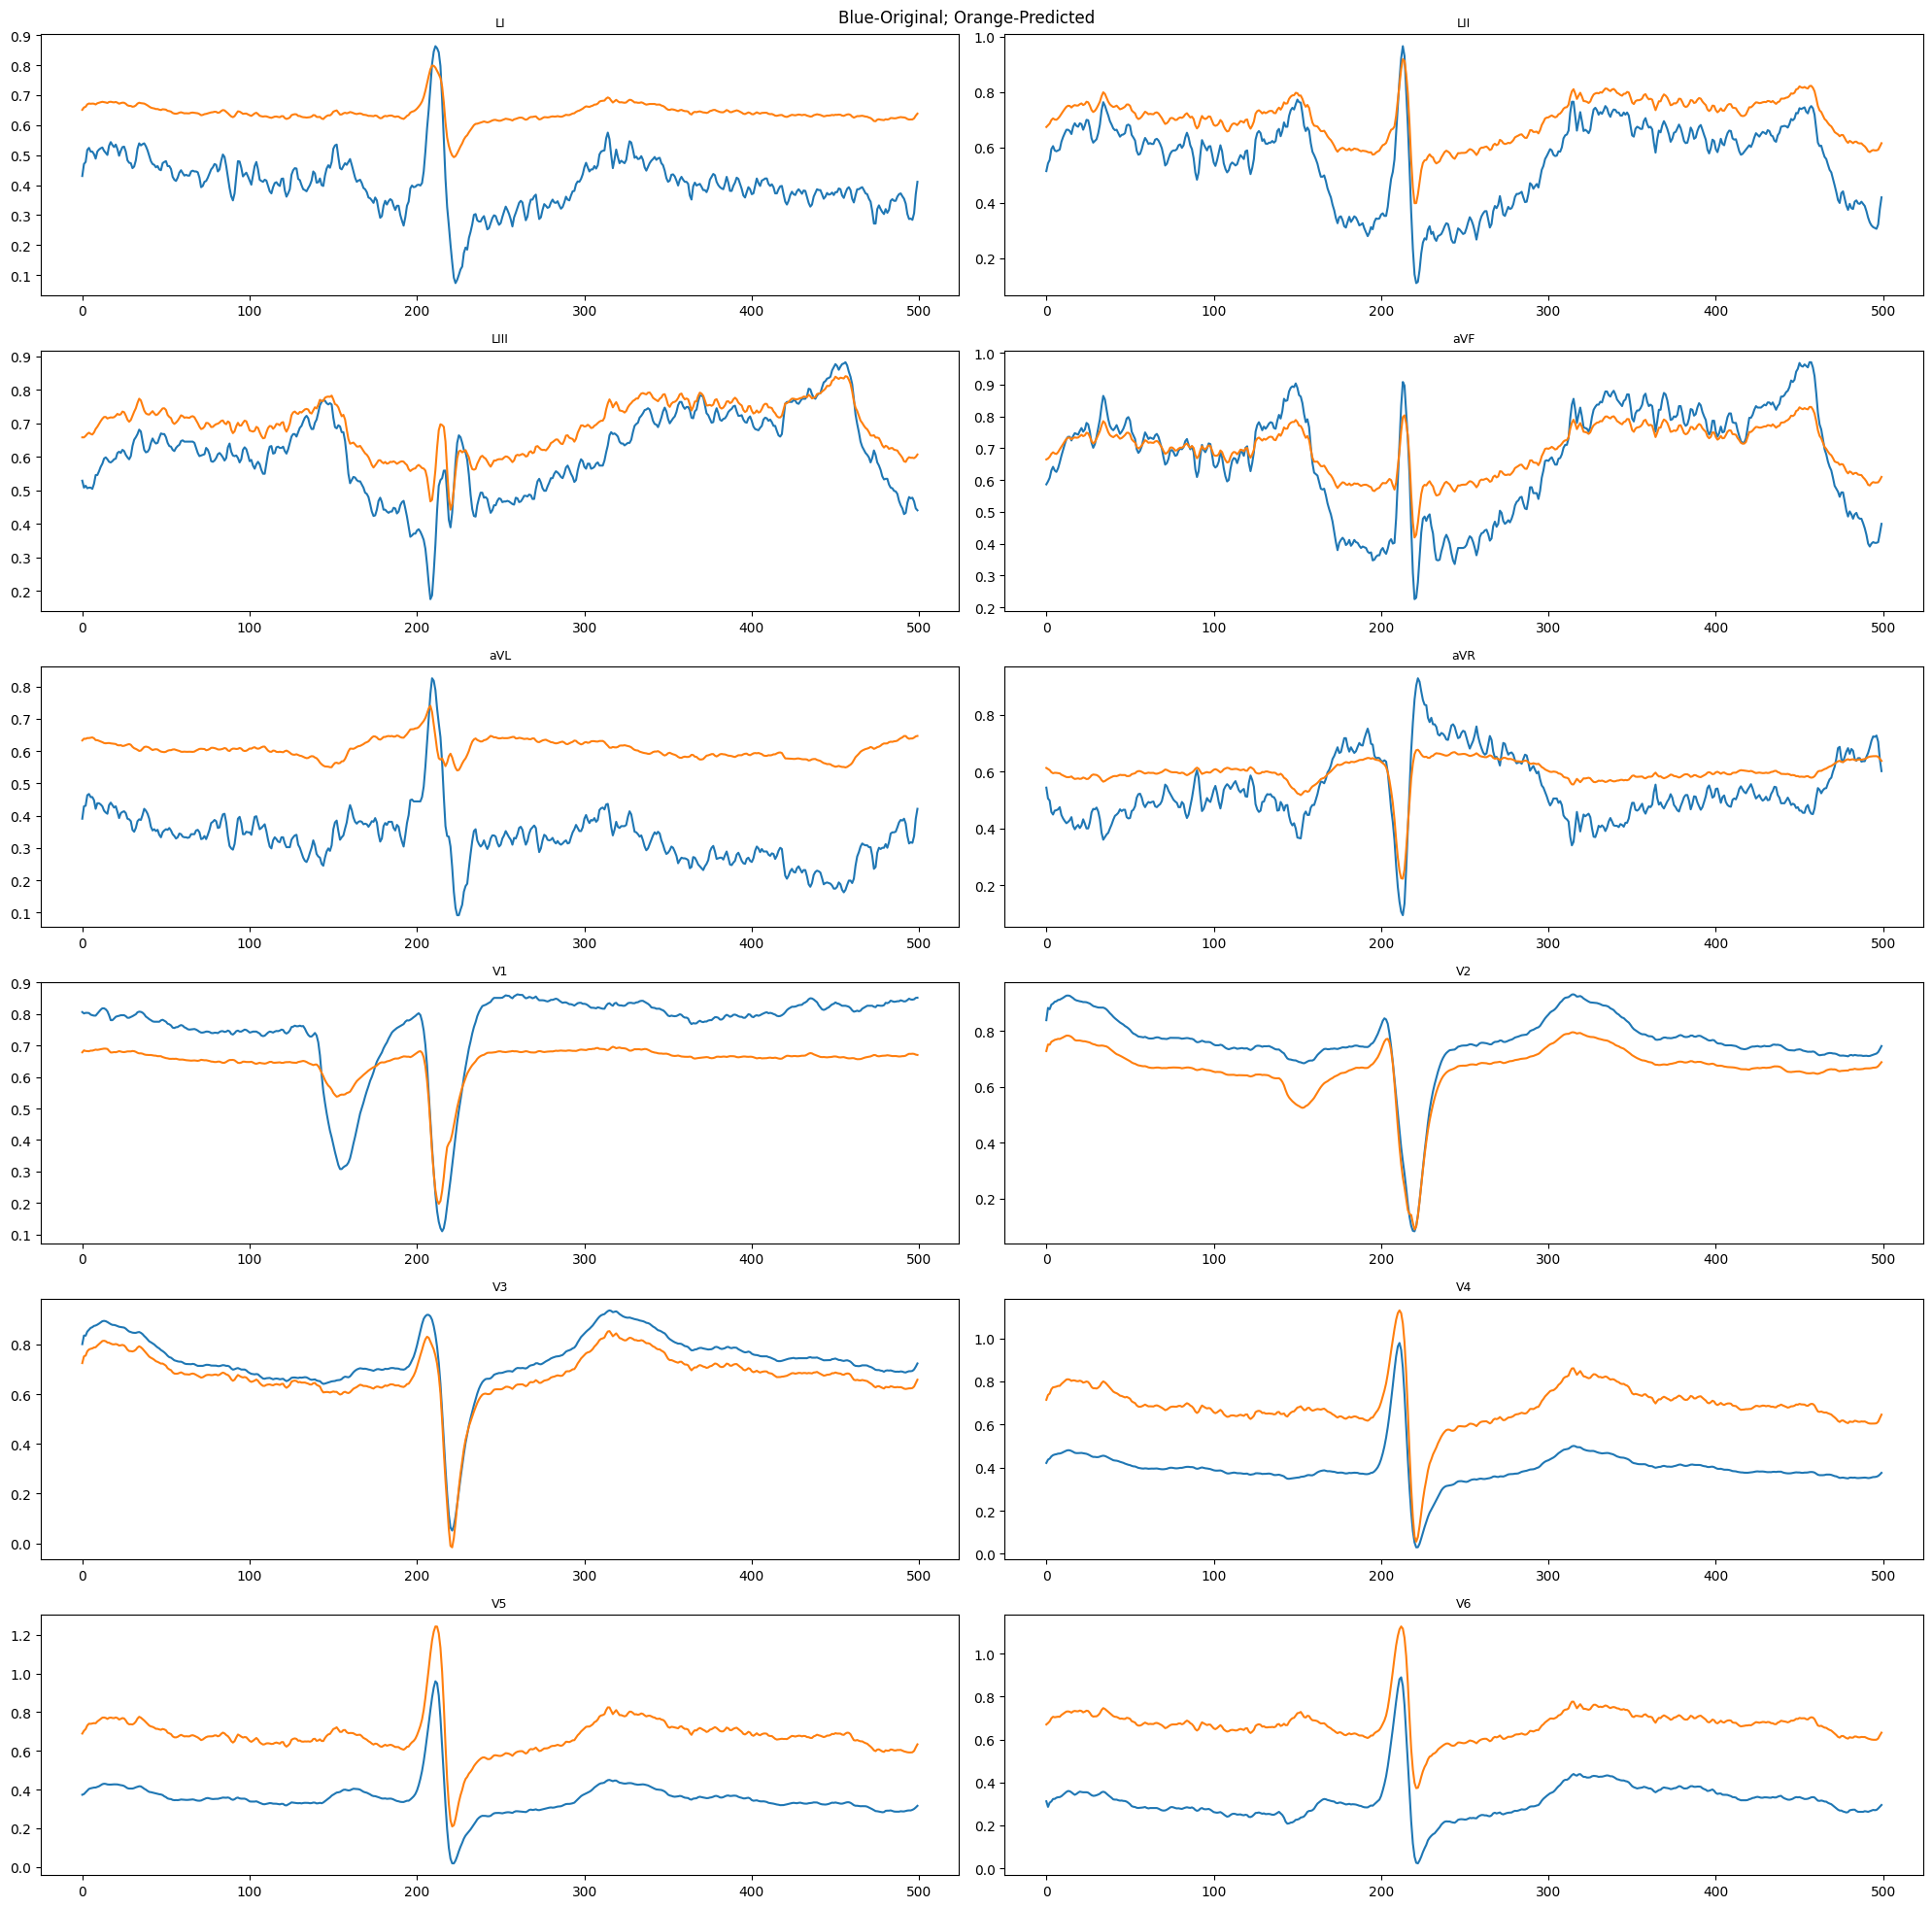

In [128]:
# Create a list of uniquely identified reading indices
signals_names = list({x.split('_')[-1] for x in df_scrutinized.index})
# Get order of leads in each reading, taken from dissertation
order_of_leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']

for j in range(10):
    i = np.random.randint(len(signals_names))

    # example
    signal_name = signals_names[i]

    # Load scalar
    scalar = MinMaxScaler()

    # Create hypotetical list of leads, it the reading was whole
    sorted_all_leads = [f'china_{x}_{signal_name}' for x in order_of_leads]

    # scale readins
    available_leads = list(df_scrutinized[df_scrutinized.index.isin(sorted_all_leads)].index)
    relevant_data_for_reading = df_scrutinized[df_scrutinized.index.isin(available_leads)].T
    scaled_reading = pd.DataFrame(scalar.fit_transform(relevant_data_for_reading).T)
    scaled_reading.index = available_leads

    # Figure out which leads are missing
    missing_leads = [x for x in sorted_all_leads if x not in available_leads]

    # Create a dataFrame
    missing_data_addition = pd.DataFrame({x:np.repeat(0,5000) for x in missing_leads}).T

    # Concat missing data and given leads
    scaled_reading_with_missing = pd.concat([scaled_reading,missing_data_addition],
                                            axis=0)
    scaled_reading_with_missing = scaled_reading_with_missing.loc[sorted_all_leads]

    # Get values and reshape according to [batch_size, channels, window] = (1, 12, 5000)
    location = 0
    window = 500
    Ys = []

    for _ in range(1):
        
        # get only relevant timestamps
        X_np = scaled_reading_with_missing.iloc[:,location:(location+window)].values
        X_np = np.expand_dims(np.float32(X_np),0)
        X_np = np.transpose(X_np, axes=(2,0,1))
        src_ = torch.from_numpy(X_np)
        src_ = src_.to(device)

        # predict
        with torch.no_grad():
            Y = model(src_,None).cpu().numpy()
        Y = np.squeeze(np.transpose(Y,axes=(2,1,0)))
        Ys.append(pd.DataFrame(Y))

        # update location on the signal
        location += window
    scaled_reading_with_imputed = pd.concat(Ys, axis=1)
    scaled_reading_with_imputed.index = sorted_all_leads

    print(f'Plotting Imputation for Reading {signal_name}')
    plot_12_signals_of_three_sources(reading   = scaled_reading_with_missing.iloc[:,0:500].values, 
                                 predicted = scaled_reading_with_imputed.iloc[:,0:500].values, 
                                 plot_saving_path=False)

# Impute Data

In [12]:
# Create a list of uniquely identified reading indices
signals_names = list({x.split('_')[-1] for x in df_scrutinized.index})

# Store imputed data
X_imputed = []
for j in tqdm(range(len(signals_names)),desc='Imputing'):
    signal_name = signals_names[j]
    predicted = predict(signal_name)
    X_imputed.append(predicted)

X_imputed = pd.concat(X_imputed)
X_imputed.to_csv('../data/one-year-project/new_china_features_05_imputed.csv')

Imputing: 100%|██████████| 3082/3082 [03:29<00:00, 14.71it/s]


# LOSS

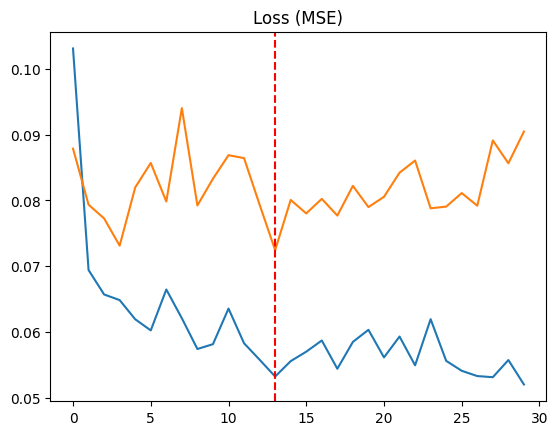

In [8]:
import os
import pickle
import matplotlib.pyplot as plt

with open('/Users/davidharar/Documents/School/thesis/upstream_seq2seq/models/exp3-base-version-with-train-by-sample_loss.pkl', 'rb') as handle:
    b = pickle.load(handle)

plt.plot(b['train'])
plt.plot(b['validation'])
plt.axvline(x=13, c = 'r', linestyle='dashed')
plt.title('Loss (MSE)')
plt.show()